In [224]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
from copy import deepcopy
import time
import json
import os 
parent = os.path.dirname(os.path.abspath("__file__"))
StrongPath = os.path.join(parent, 'StrongTickers')
if not os.path.isdir(StrongPath):
    os.makedirs(StrongPath)
hDataPath = os.path.join(parent, "TickDatas")    
if not os.path.isdir(hDataPath):
    os.makedirs(hDataPath)

# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
api = sj.Shioaji()
api.login('F128497445', '89118217k')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [4]:
def ReadEarnedTicks():
    earned_ticks = {'price':[], 'ticks':[]}
    with open(os.path.join(parent, 'EarnedTicks.txt'), "r") as f:
        lines = f.readlines()
        for line in lines[1:]:
            earned_ticks['price'].append(int(line.split(',')[0]))
            earned_ticks['ticks'].append(int(line.split(',')[1].strip()))
            
        return earned_ticks

In [5]:
earned_ticks = ReadEarnedTicks()

In [6]:
def getEarnedTicks(entry_price):
    tmp_p = deepcopy(earned_ticks['price'])
    tmp_t = deepcopy(earned_ticks['ticks'])
    tmp_p.append(entry_price)
    tmp_p = sorted(tmp_p)
    idx = tmp_p.index(entry_price)
    return tmp_t[idx]

In [7]:
def getTargetPrice(entry_price, sl=False):
    num_ticks = getEarnedTicks(entry_price)
    for i in range(num_ticks+bool(sl)*2):
        entry_price += get_minimum_tick(entry_price)
    return round(entry_price, 2)

In [8]:
results = {}

In [38]:
from typing import Callable, List
from enum import Enum

from datetime import datetime, timedelta

from typing import List
from copy import deepcopy

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
class BaseData(AttrDict):
    
    def __init__(self, *args, **kwargs):
        super(BaseData, self).__init__(*args, **kwargs)
        
class TickData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(TickData, self).__init__(*args, **kwargs)
        
class BarData(BaseData):
    """
    儲存即時收到的Info報價
    """
    def __init__(self, *args, **kwargs):
        super(BarData, self).__init__(*args, **kwargs)

class TradeMode(Enum):
    """
    交易模式
    """
    REALTIME = '實盤交易'
    SIMULATION = '模擬交易'
    BACKTEST = '回測'
    BACKTESTINTRADAY = '日內回測'

# 資料格式 (RealTime)
class Interval(Enum):
    """
    資料頻率
    """
    TICK = '逐筆'
    MINUTE = '分K'
    HOUR = '小時K'
    DAILY = '日K'

class BarGenerator:
    """
    For:
    1. generateing x minute bar/x hour bar data from tick data

    Notice:
    1. x can be any number
    """

    def __init__(self, ticker: str, interval: Interval = Interval.MINUTE, window: int = 5,
                 trademode: TradeMode = TradeMode.REALTIME, 
                 callback: Callable = None, size=15, date=datetime.today()):
        """
        Constructor
        """
        self.ticker = ticker
        self.interval = interval
        self.window = window
        self._trademode = trademode
        self.callback = callback

        self.setupBarCycle(interval, window)
        self.bars: List[BarData] = []
        self.inited = False
        self.barCount = 0
        self.size = size
        self.date = date

    def setupBarCycle(self, interval, window) -> None:
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            self.current = date.replace(hour=9,minute=0,second=0,microsecond=0)#datetime.now().replace(second=0)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            self.current = 84500
        self._intervalCycle(interval, window)

    def _intervalCycle(self, interval: Interval, window: int):
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            if interval == Interval.MINUTE:
                self.cycle = timedelta(seconds=60 * window)
            elif interval == Interval.HOUR:
                self.cycle = timedelta(seconds=60 * 60 * window)
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            if interval == Interval.MINUTE:
                self.cycle = 100 * window
            elif interval == Interval.HOUR:
                self.cycle = 100 * 100 * window

    def updateBar(self, tick: TickData):
        try:
            if self._trademode == TradeMode.BACKTESTINTRADAY:
                return self._updateBarBacktest(tick)
            return self._updateBar(tick)
        except:
            raise

    def _updateBar(self, tick: TickData):
        try:
            try:
                time, close, volume = tick.time, tick.close, tick.volume
            except:
                # print(tick)
                time, close, volume = tick['time'], tick['close'], tick['volume']
#             print(pd.to_datetime(time), self.current)
            if not self.bars or time > self.current:
                self.bars.append(self._createNewBar(time, close, volume))
                self._updateCurBarTime()
                if len(self.bars) >= self.size:
                    self.inited = True
                if len(self.bars) > 1:
#                     print(self.bars[-2])
                    return self.bars[-2]
                    if self.callback:
                        self.callback(self.bars[-2])
            else:
                self._updateCurBar(close, volume)
        except:
            raise

    def _updateBarBacktest(self, tick: TickData):
        time, close, volume = tick.time, tick.close, tick.volume
        if not self.bars or time > self.current:
            self.bars.append(self._createNewBar(time, close, volume))
            self._updateCurBarTime()
            if len(self.bars) >= self.size:
                self.inited = True
            if len(self.bars) > 1:
                self.callback(self.bars[-2])
        else:
            self._updateCurBar(close, volume)
            
    def _createNewBar(self, time, close, volume):
        return BarData(
                    symbol=self.ticker,
                    time=time,
                    open=close,
                    high=close,
                    low=close,
                    close=close,
                    volume=volume
                )
    
    def _updateCurBar(self, close, volume):
        curBar = self.bars[-1]
        curBar.high = max(curBar.high, close)
        curBar.low = min(curBar.low, close)
        curBar.close = close
        curBar.volume += volume
        self.bars[-1] = curBar

    def _updateCurBarTime(self):
        self.current += self.cycle
        if self._trademode in [TradeMode.REALTIME, TradeMode.SIMULATION]:
            return
        elif self._trademode == TradeMode.BACKTESTINTRADAY:
            timeList = self._intTolist(self.current)
            if self.interval == Interval.MINUTE:
                if timeList[1] >= 60:
                    timeList[0] += 1
                    timeList[1] -= 60
            if timeList[0] >= 24:
                timeList[0] -= 24
            self.current = int(''.join([str(int(x)) for x in timeList]))

    def _intTolist(self, t):
        ss = t % 100
        t /= 100
        mm = t % 100
        hh = t / 100
        return [int(hh), int(mm), int(ss)]

    @property
    def closes(self):
        return [getattr(bar, 'close') for bar in self.bars][:-1]

    @property
    def opens(self):
        return [getattr(bar, 'open') for bar in self.bars][:-1]

    @property
    def highs(self):
        return [getattr(bar, 'high') for bar in self.bars][:-1]

    @property
    def lows(self):
        return [getattr(bar, 'low') for bar in self.bars][:-1]

    @property
    def volumes(self):
        return [getattr(bar, 'volume') for bar in self.bars][:-1]

In [10]:
def readStrongTicker(dtStr, atr=""):
    datapath = os.path.join(StrongPath+atr, f'{dtStr}_tradableTicker.json')
    if not os.path.isfile(datapath):
        datapath = os.path.join(StrongPath+atr, f'{dtStr}_strongTicker.json')
#         with open(os.path.join(StrongPath, f'{dtStr}_tradableTicker.json'), 'r') as f:
#             tickers = json.load(f)
#             return tickers
    if os.path.isfile(datapath):
        with open(datapath, 'r') as f:
            tickers = json.load(f)
            return tickers
    else:
        return {}

def get_minimum_tick(cost):
    if cost < 10:
        return 0.01
    elif cost < 50:
        return 0.05
    elif cost < 100:
        return 0.1
    elif cost < 500:
        return 0.5
    elif cost < 1000:
        return 1
    else:
        return 5
    
def get_commission(price:float, multiplier:int=1000, qty=1, Real:bool=True, direction:str='', dayTrade:bool=False):
    """
    計算個別部位的單邊交易成本

    Params:
        symbol : 商品代碼
        exchange : 交易所
        cost : 交易價格
        multiplier : 價格還原現金之乘數
            例如:
                股票 : 1張 = 1,000股，10元的股票還原現金價值，即為10 *1,000 = 10,000元
                期貨 : 台指期1點200元，假設現在10,000點，則一口台股的價值為 200 * 10,000 = 2,000,000
        qty : 買賣口數或張數
        Real : 是否為實單, default = False
        direction : 交易方向 進場(買賣)或出場
            P.S. 股票交易的交易稅是出場才計算
    """
    tick = get_minimum_tick(price)
    commission = price * (0.1425 / 100) * multiplier * qty
    commission = 20 if commission < 20 else commission
    fee = price * (0.3 / 100) * multiplier * qty
    if dayTrade:
        fee /= 2
    slide = tick * multiplier
    tradeCost = commission * 0.6
    if direction == 'EXIT' or direction == 0:
        tradeCost += fee
    if not Real:
        tradeCost += slide * qty
    return tradeCost

In [40]:
def ReadData(api, ticker, date):
    data_path = os.path.join(hDataPath, str(date.year).zfill(4), str(date.month).zfill(2), str(date.day).zfill(2))
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    f_path = os.path.join(data_path, f'{ticker}.txt')
    if os.path.isfile(f_path):
        df = pd.read_csv(f_path, encoding='utf-8')
        df['datetime'] = pd.to_datetime(df['datetime'])
    else:
        dateStr = date.strftime("%Y-%m-%d")
        contact = api.Contracts.Stocks[ticker]
        data = api.ticks(contact, dateStr, 
                query_type=sj.constant.TicksQueryType.RangeTime, 
                time_start='09:00:00',#datetime(2021,11,5,8,45,0).time(),
               time_end='13:30:00')#datetime(2021,11,5,13,45,0).time())
        df = pd.DataFrame(data.dict())
        df['datetime'] = df.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')))
        df['datetime'] = pd.to_datetime(df['datetime'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f")))
        df.to_csv(f_path, encoding='utf-8',index=False)
#     print(df)
    return df

In [52]:
def backtest(api:sj.Shioaji, ticker:str, date:datetime, open_threshold:float=0, PreData:dict={},
             v_threshold:float=.01, entry_percent:float=.06, exit_percent:float=.09, 
             takeprofit:float=.6, start_moving_take = .015, sl_ratio:float=.02, max_size:float = 1, 
             exit_time:str='13:00:00.000000'): # 

    # prepare data
    df = ReadData(api, ticker, date)
    
    # setting Parameters
    opening = False
    closing = False
    
    pre_time:str="09:00:00"
    pre_volume:int = 0
    pre_close:int = 0
    total_v:int = 0 
    refPrice:float = PreData.get('PreClose', 0)
    preHigh:float = PreData.get('PreHigh', PreData.get('PreClose', 0))
#     preLow:float = PreData.get('PreLow', 9999)
    entry_threshold:float = 0 if not refPrice else refPrice * (1 + entry_percent)
    exit_threshold:float = 0 if not refPrice else refPrice * (1 + exit_percent)
    max_ret:float = 0
    tmp_ret:float = 0
    pos = 0
    sig = 0
    traded = 0
    long_traded = short_traded = 0
    entry = 0
    entry_time = 0

#     preHigh = 0
#     preLow = 9999
    sl_threshold = 0
    short_sl_ratio = .02
    
    pnl:float = 0
    total_volume = 0
#     first_5mink = {'open':None, 'high':0,'low':9999, 'close':0}
        
    entry_time = ''
    exit_pos_time = ''
    tmp_pnl = 0
    barG = BarGenerator(ticker, date=date)
    open_l = open_h = None
    total_pnl = 0
    
    for row in df.itertuples():
#         print(row)
        price = row.close
        time = row.datetime
        qty = row.volume
        if not qty: continue
        total_volume += qty
        tick = TickData(time=time, close=price,volume=qty)
        update_bar = barG.updateBar(tick)
        if update_bar and not pos:
#             print(update_bar)
            if len(barG.bars) >= 3 and not (open_h and open_l):
                open_h = max(barG.highs[:2])
                open_l = min(barG.lows[:2])
                print(f"open_h : {open_h}, open_l : {open_l}")
        if len(barG.bars) < 2:
            continue
        if time <= time.replace(hour=13,minute=0,second=0, microsecond=0) and not pos:
            if not pos and not sig and not traded: # check signal without position
#                 if not short_traded:
                if open_l and price < open_l and row.datetime.strftime('%H:%M:%S.%f') >= "12:00:00.000000" and not short_traded:
                    print("Entry Short signal with price touch")
                    sig = -1
                    oneTradeOnly = True
                elif update_bar and open_l and update_bar['close'] < open_l and not short_traded: # update_bar['open']
                    print(f"5m Bar CLose :{update_bar['close']}, open low : {open_l}")
                    print("Entry Short signal with price low open threshold")
#                     print(','.join([str(x) for x in [update_bar['close'], open_l]]))
                    sig = -1
                    oneTradeOnly = True
#                 elif update_bar and open_h and update_bar['close'] > open_h and update_bar['close'] <= entry_threshold and not long_traded:
                elif price > max(barG.bars[0]['open'], barG.bars[0]['close'],preHigh) * 1.005 and price <= entry_threshold and not long_traded: # ,preHigh
                    sig = 1
                    oneTradeOnly = True
            elif not pos and sig: # entry market
                print(f"Entry at close = {price}, bid : {row.bid_price}, ask : {row.ask_price}")
                if sig > 0:
                    entry = row.ask_price
                elif sig < 0:
                    entry = row.bid_price
                if abs(entry / price - 1) >= .005:
                    entry = price
                pos, sig = sig, 0
                entry_time = row.datetime
                sl_threshold = entry * (1 - sl_ratio * pos)
                if pos == -1:
                    short_sl_ratio = open_h / entry - 1
                    sl_threshold = entry * (1 - short_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
                    
                    
        elif pos and not sig: # check signal with position
            tmp_ret = price / entry - 1
            tmp_ret *= pos
#             tmp_pnl = (price - entry) * 1000 * pos
#             tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
#             tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
#             if pos > 0:
#                 tmp_ret = ((price / entry) - 1) * pos
#             else:
#                 tmp_ret = (tmp_pnl / (entry * 1000))# - 1
#             print(f"Tmp PnL : {tmp_pnl}")
            
#             if tmp_ret > max_ret:
# #                 sl_threshold = entry * (1 - sl_ratio * pos)
#                 sl_threshold = price * (1 - sl_ratio * pos)
#                 if pos == -1:
#                     sl_threshold = price * (1 - short_sl_ratio * pos)
#                     sl_threshold = min(sl_threshold, (open_h + open_l) / 2)
#                 sl_threshold = min(price * (1 - sl_ratio * pos), (open_h + open_l) / 2)
#                 print(row.datetime, price * (1 + sl_ratio), (open_h + open_l) / 2, sl_threshold)
            max_ret = max(tmp_ret, max_ret)
#             print(f"close : {price}, pos : {pos}, tmp_pnl : {tmp_pnl}, max_ret : {max_ret}")

            do_exit_take = tmp_ret > takeprofit # and ((entry_time.strftime('%H:%M:%S.%f') >= "12:00:00.000000") or pos == 1)
#             if max_ret >= start_moving_take:
#                 do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
            do_exit_stop = 0 # price > sl_threshold if pos == -1 else price < sl_threshold
            do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))

            exit_end = time.strftime('%H:%M:%S.%f') >= exit_time
            if any([do_exit, do_exit_stop, exit_end, do_exit_take]): # 
                print(do_exit, do_exit_stop, exit_end, do_exit_take)
                print(f"sl_threshold {sl_threshold}, half-high-low :{(open_h + open_l) / 2}")
                print(f"Max Ret : {max_ret}")
                sig = -pos
                print(f"Signal For Exit : {sig}")
#                     self.closing=True
#                     self.DoTrade('S' if self.pos > 0 else 'B')
#                     self.sendNotifyExit(self.q20_data['datetime'].strftime("%H:%M:%S.%f"), self.symbol, self.name,
#                                      close, self.q20_data['pct_chg'], do_exit_take or do_exit)
        elif pos and sig:
            signal_time = row.datetime
            print(f"Calculate PnL at close = {price}, ask : {row.ask_price} at {row.datetime}")
            if sig > 0:
                exit = row.ask_price
            elif sig < 0:
                exit = row.bid_price
            if abs(exit / price - 1) >= .005:
                exit = price
            tmp_pnl = (exit - entry) * 1000 * pos
            tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
            tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
            tmp_ret = ((price / entry) - 1) * pos
            total_pnl += tmp_pnl
            
            print('\n---------------PnL Summary--------------')
            print(f'Exit Position of {ticker}')
            print(f'Entry : {entry} at {entry_time}')
            print(f'Exit : {price} at {signal_time}')
            print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
            print(f'Total PnL with Cost : {int(round(total_pnl))}')
            print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
            print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
            
            if pos > 0:
                long_traded = True
            elif pos < 0:
                short_traded = True
            sig = pos = 0
            traded = (long_traded and short_traded) or (total_pnl > 0)
            exit_pos_time = row.datetime
        else:
            if pos and not sig:
                tmp_pnl = (price - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else price)) # 進場成本
                tmp_pnl -= int(get_commission(price if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
#                 tmp_ret = (tmp_pnl / entry * 1000) - 1
                if tmp_ret > max_ret:
                    sl_threshold = price * (1 - sl_ratio)
                max_ret = max(tmp_ret, max_ret)

                do_exit_take = do_exit_take = tmp_ret >= 0.01 # False
#                 if max_ret >= start_moving_take:
#                     do_exit_take = (tmp_ret / max_ret) <= (takeprofit) if max_ret else False
                do_exit_stop = price > sl_threshold if pos == -1 else price < sl_threshold
                do_exit = price >= exit_threshold if pos > 0 else price <= (refPrice * (1 - exit_percent))
                sig = -pos
            elif pos and sig:
                signal_time = row.datetime
                print(price, row.bid_price)
                exit = row.bid_price
                if abs(exit / price - 1) >= .005:
                    exit = price
                tmp_pnl = (exit - entry) * 1000 * pos
                tmp_pnl -= int(get_commission(entry if pos > 0 else exit)) # 進場成本
                tmp_pnl -= int(get_commission(exit if pos > 0 else entry, direction='EXIT', dayTrade=True)) # 出場成本
                tmp_ret = ((price / entry) - 1) * pos
                total_pnl += tmp_pnl
                
            
                print('\n---------------PnL Summary--------------')
                print(f'Exit Position of {ticker}')
                print(f'Entry : {entry} at {entry_time}')
                print(f'Exit : {price} at {signal_time}')
                print(f'Trading PnL with Cost : {int(round(tmp_pnl))}')
                print(f'Total PnL with Cost : {int(round(total_pnl))}')
                print(f'Total Ret with Cost : {round(tmp_ret * 100, 2)}%')
                print(f'Total PnL with Cost of max size {max_size}: {max_size * int(round(tmp_pnl))}\n')
                
                if pos > 0:
                    long_traded = True
                elif pos < 0:
                    short_traded = True
                sig = pos = 0
                traded = (long_traded and short_traded) or (total_pnl > 0)
                exit_pos_time = row.datetime
    return int(round(total_pnl))

In [104]:
def doSingleBacktest(api, ticker, date, open_thresholds, takeprofit=.005):
    df = ReadData(api, ticker, date)
#     df.set_index("datetime").close.plot(figsize=(12,8))
    return backtest(api, ticker, date, open_thresholds['PreClose'], 
             PreData=open_thresholds, max_size=max_size_map[ticker], 
             takeprofit=takeprofit, sl_ratio=0.02)

def doAllBacktest(api, date, open_thresholds, takeprofit=.005):
    pnl_ = {}
    for ticker, v in open_thresholds.items():
        try:
            if v['PreClose'] > 1000:continue
            print(f'backtest : {ticker}')
            pnl_[ticker] = doSingleBacktest(api, ticker, date, v, takeprofit=takeprofit)
        except Exception as e:
            print(ticker, e)
            pass
    return pnl_

In [225]:
# from 2021-11-29
for date in pd.date_range(datetime(2022,2,9), datetime(2022,9,23)):
    # date = datetime(2022,2,8)
    # date = datetime(2021,12,31)
    try:
        open_thresholds = readStrongTicker(date.strftime("%Y-%m-%d"))#, 'ATR')
        total_capital = 5e6
        seperated_capital = int(total_capital / len(open_thresholds.keys()))
        max_size_map = {}
        for k, v in open_thresholds.items():
            try:
                max_pos = int(seperated_capital / (v['PreClose'] * 1000))
                print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
                max_size_map[k] = max_pos
            except:
                max_pos = int(seperated_capital / (v * 1000))
                print(f'{k} 最大倉位 : {max_pos}, 昨收 : {v}')
                max_size_map[k] = max_pos
                open_thresholds[k] = {'PreClose':v}
    except:
        continue
    pnl_ = doAllBacktest(api, date, open_thresholds, takeprofit=.005)
    single_pnl = 0
    max_pnl = 0
    trade_value = 0
    for ticker in pnl_.keys():
#         print(ticker, pnl_[ticker])
        if pnl_[ticker]:
            trade_value += open_thresholds[ticker]['PreClose'] * 1000
        single_pnl += pnl_[ticker]
        max_pnl += pnl_[ticker] * max_size_map[ticker]

    print(f'交易量 : {trade_value}')
    print(f'手續費折讓 : {round(trade_value * 1.425e-3 * (0.6 * 0.55)*2)}')
    print(f'single pnl sum : {single_pnl}')
    print(f'max pnl sum : {max_pnl}')
    results[date] = single_pnl
    time.sleep(10)

2233 最大倉位 : 5, 昨收 : {'PreClose': 119.0, 'PreHigh': 119.0, 'PreLow': 108.0}
2305 最大倉位 : 55, 昨收 : {'PreClose': 11.3, 'PreHigh': 11.35, 'PreLow': 10.4}
2399 最大倉位 : 28, 昨收 : {'PreClose': 21.75, 'PreHigh': 21.75, 'PreLow': 20.35}
2465 最大倉位 : 8, 昨收 : {'PreClose': 73.5, 'PreHigh': 73.5, 'PreLow': 67.6}
3535 最大倉位 : 30, 昨收 : {'PreClose': 20.75, 'PreHigh': 20.75, 'PreLow': 18.9}
6205 最大倉位 : 7, 昨收 : {'PreClose': 80.8, 'PreHigh': 80.8, 'PreLow': 75.3}
4513 最大倉位 : 38, 昨收 : {'PreClose': 16.35, 'PreHigh': 16.35, 'PreLow': 15.0}
8440 最大倉位 : 18, 昨收 : {'PreClose': 33.45, 'PreHigh': 33.45, 'PreLow': 31.6}
backtest : 2233
open_h : 119.0, open_l : 116.0
Entry at close = 120.0, bid : 119.5, ask : 120.0
False 0 False True
sl_threshold 117.6, half-high-low :117.5
Max Ret : 0.008333333333333304
Signal For Exit : -1
Calculate PnL at close = 121.0, ask : 121.0 at 2022-02-09 09:54:48

---------------PnL Summary--------------
Exit Position of 2233
Entry : 120.0 at 2022-02-09 09:54:44
Exit : 121.0 at 2022-02-09 09:

open_h : 91.3, open_l : 88.6
5m Bar CLose :88.5, open low : 88.6
Entry Short signal with price low open threshold
Entry at close = 88.5, bid : 88.4, ask : 88.6
False 0 False True
sl_threshold 91.3, half-high-low :89.94999999999999
Max Ret : 0.005656108597285048
Signal For Exit : 1
Calculate PnL at close = 87.9, ask : 88.0 at 2022-02-10 09:30:58

---------------PnL Summary--------------
Exit Position of 5245
Entry : 88.4 at 2022-02-10 09:30:01
Exit : 87.9 at 2022-02-10 09:30:58
Trading PnL with Cost : 117
Total PnL with Cost : 117
Total Ret with Cost : 0.57%
Total PnL with Cost of max size 4: 468

backtest : 5344
Entry at close = 27.75, bid : 27.3, ask : 27.85
False 0 True False
5344 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 6104
open_h : 258.0, open_l : 250.5
5m Bar CLose :248.5, open low : 250.5
Entry Short signal with price low open threshold
Entry at close = 248.5, bid : 248.5, ask : 249.0
False 0 False True
sl_threshold 258.0, half-high-low :254.25
Max

open_h : 48.35, open_l : 47.65
Entry at close = 48.4, bid : 48.3, ask : 48.4
False 0 False True
sl_threshold 47.431999999999995, half-high-low :48.0
Max Ret : 0.005165289256198413
Signal For Exit : -1
Calculate PnL at close = 48.5, ask : 48.55 at 2022-02-17 09:10:26

---------------PnL Summary--------------
Exit Position of 2457
Entry : 48.4 at 2022-02-17 09:10:06
Exit : 48.5 at 2022-02-17 09:10:26
Trading PnL with Cost : -55
Total PnL with Cost : -55
Total Ret with Cost : 0.21%
Total PnL with Cost of max size 11: -605

Entry Short signal with price touch
Entry at close = 47.6, bid : 47.6, ask : 47.65
False 0 False True
sl_threshold 48.35, half-high-low :48.0
Max Ret : 0.005252100840336116
Signal For Exit : 1
Calculate PnL at close = 47.35, ask : 47.4 at 2022-02-17 12:06:50

---------------PnL Summary--------------
Exit Position of 2457
Entry : 47.6 at 2022-02-17 12:05:40
Exit : 47.35 at 2022-02-17 12:06:50
Trading PnL with Cost : 48
Total PnL with Cost : -7
Total Ret with Cost : 0.53%

Entry at close = 45.9, bid : 45.8, ask : 45.9
False 0 False True
5608 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 5706
open_h : 59.4, open_l : 57.0
5m Bar CLose :56.9, open low : 57.0
Entry Short signal with price low open threshold
Entry at close = 56.8, bid : 56.8, ask : 56.9
False 0 True False
sl_threshold 59.4, half-high-low :58.2
Max Ret : 0.0017605633802816323
Signal For Exit : 1
Calculate PnL at close = 59.2, ask : 59.3 at 2022-02-21 13:00:08

---------------PnL Summary--------------
Exit Position of 5706
Entry : 56.8 at 2022-02-21 09:30:02
Exit : 59.2 at 2022-02-21 13:00:08
Trading PnL with Cost : -2683
Total PnL with Cost : -2683
Total Ret with Cost : -4.23%
Total PnL with Cost of max size 7: -18781

backtest : 9955
open_h : 24.25, open_l : 23.0
5m Bar CLose :22.75, open low : 23.0
Entry Short signal with price low open threshold
Entry at close = 22.75, bid : 22.75, ask : 22.8
False 0 True False
sl_threshold 24.25, half-high-low :23.625
Max Ret : 0.

open_h : 8.97, open_l : 8.6
5m Bar CLose :8.51, open low : 8.6
Entry Short signal with price low open threshold
Entry at close = 8.5, bid : 8.5, ask : 8.51
False 0 False True
sl_threshold 8.97, half-high-low :8.785
Max Ret : 0.005882352941176561
Signal For Exit : 1
Calculate PnL at close = 8.43, ask : 8.42 at 2022-02-22 11:08:02

---------------PnL Summary--------------
Exit Position of 4804
Entry : 8.5 at 2022-02-22 09:25:25
Exit : 8.43 at 2022-02-22 11:08:02
Trading PnL with Cost : 44
Total PnL with Cost : 44
Total Ret with Cost : 0.82%
Total PnL with Cost of max size 43: 1892

backtest : 6134
open_h : 28.75, open_l : 27.7
Entry at close = 28.75, bid : 28.75, ask : 28.8
False 0 False True
sl_threshold 28.224, half-high-low :28.225
Max Ret : 0.005208333333333259
Signal For Exit : -1
Calculate PnL at close = 28.95, ask : 28.95 at 2022-02-22 09:32:38

---------------PnL Summary--------------
Exit Position of 6134
Entry : 28.8 at 2022-02-22 09:32:37
Exit : 28.95 at 2022-02-22 09:32:38
Tr

open_h : 115.5, open_l : 112.0
5m Bar CLose :110.5, open low : 112.0
Entry Short signal with price low open threshold
Entry at close = 110.5, bid : 110.5, ask : 111.0
False 0 False True
sl_threshold 115.5, half-high-low :113.75
Max Ret : 0.009049773755656076
Signal For Exit : 1
Calculate PnL at close = 109.5, ask : 110.0 at 2022-03-01 09:33:44

---------------PnL Summary--------------
Exit Position of 1795
Entry : 110.5 at 2022-03-01 09:30:01
Exit : 109.5 at 2022-03-01 09:33:44
Trading PnL with Cost : 146
Total PnL with Cost : 146
Total Ret with Cost : 0.9%
Total PnL with Cost of max size 6: 876

backtest : 2032
open_h : 29.6, open_l : 29.6
backtest : 2617
open_h : 38.95, open_l : 37.6
5m Bar CLose :37.05, open low : 37.6
Entry Short signal with price low open threshold
Entry at close = 37.05, bid : 37.0, ask : 37.05
False 0 False True
sl_threshold 38.95, half-high-low :38.275000000000006
Max Ret : 0.005405405405405461
Signal For Exit : 1
Calculate PnL at close = 36.85, ask : 36.9 at 2

open_h : 24.35, open_l : 24.35
backtest : 2033
open_h : 22.5, open_l : 22.0
5m Bar CLose :21.5, open low : 22.0
Entry Short signal with price low open threshold
Entry at close = 21.4, bid : 21.4, ask : 21.5
False 0 True False
sl_threshold 22.500000000000004, half-high-low :22.25
Max Ret : 0.004672897196261627
Signal For Exit : 1
Calculate PnL at close = 21.4, ask : 21.5 at 2022-03-03 13:00:08

---------------PnL Summary--------------
Exit Position of 2033
Entry : 21.4 at 2022-03-03 10:20:01
Exit : 21.4 at 2022-03-03 13:00:08
Trading PnL with Cost : -168
Total PnL with Cost : -168
Total Ret with Cost : -0.0%
Total PnL with Cost of max size 26: -4368

backtest : 2430
open_h : 47.9, open_l : 45.0
backtest : 2498
Entry at close = 68.1, bid : 68.1, ask : 68.3
False 0 False True
2498 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2611
open_h : 26.05, open_l : 24.9
5m Bar CLose :24.85, open low : 24.9
Entry Short signal with price low open threshold
Entry at close = 2

open_h : 27.8, open_l : 26.8
backtest : 3169
open_h : 232.5, open_l : 222.0
5m Bar CLose :220.5, open low : 222.0
Entry Short signal with price low open threshold
Entry at close = 220.5, bid : 220.5, ask : 221.0
False 0 False True
sl_threshold 232.5, half-high-low :227.25
Max Ret : 0.006802721088435382
Signal For Exit : 1
Calculate PnL at close = 219.0, ask : 219.0 at 2022-03-07 09:45:47

---------------PnL Summary--------------
Exit Position of 3169
Entry : 220.5 at 2022-03-07 09:45:04
Exit : 219.0 at 2022-03-07 09:45:47
Trading PnL with Cost : 794
Total PnL with Cost : 794
Total Ret with Cost : 0.68%
Total PnL with Cost of max size 5: 3970

交易量 : 261250.0
手續費折讓 : 246
single pnl sum : 861
max pnl sum : 7052
2024 最大倉位 : 34, 昨收 : {'PreClose': 29.4, 'PreHigh': 29.4, 'PreLow': 25.7}
2032 最大倉位 : 29, 昨收 : {'PreClose': 33.6, 'PreHigh': 33.6, 'PreLow': 31.0}
2033 最大倉位 : 42, 昨收 : {'PreClose': 23.4, 'PreHigh': 23.4, 'PreLow': 20.8}
5225 最大倉位 : 40, 昨收 : {'PreClose': 24.5, 'PreHigh': 24.5, 'PreLo

Entry at close = 59.2, bid : 59.1, ask : 59.2
False 0 False True
6477 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 8163
open_h : 48.85, open_l : 48.45
5m Bar CLose :48.4, open low : 48.45
Entry Short signal with price low open threshold
Entry at close = 48.4, bid : 48.4, ask : 48.45
False 0 False True
sl_threshold 48.85000000000001, half-high-low :48.650000000000006
Max Ret : 0.005165289256198302
Signal For Exit : 1
Calculate PnL at close = 48.15, ask : 48.25 at 2022-03-10 10:00:02

---------------PnL Summary--------------
Exit Position of 8163
Entry : 48.4 at 2022-03-10 09:20:10
Exit : 48.15 at 2022-03-10 10:00:02
Trading PnL with Cost : -4
Total PnL with Cost : -4
Total Ret with Cost : 0.52%
Total PnL with Cost of max size 7: -28

backtest : 2064
open_h : 26.8, open_l : 24.6
Entry at close = 26.25, bid : 26.05, ask : 26.25
False 0 False True
sl_threshold 25.724999999999998, half-high-low :25.700000000000003
Max Ret : 0.005714285714285561
Signal For Exit : -

open_h : 195.0, open_l : 188.0
Entry at close = 192.5, bid : 191.5, ask : 192.5
False 0 False True
sl_threshold 188.65, half-high-low :191.5
Max Ret : 0.0051948051948051965
Signal For Exit : -1
Calculate PnL at close = 193.5, ask : 193.5 at 2022-03-11 09:38:37

---------------PnL Summary--------------
Exit Position of 8155
Entry : 192.5 at 2022-03-11 09:36:26
Exit : 193.5 at 2022-03-11 09:38:37
Trading PnL with Cost : -118
Total PnL with Cost : -118
Total Ret with Cost : 0.52%
Total PnL with Cost of max size 2: -236

backtest : 8440
open_h : 58.1, open_l : 55.8
Entry Short signal with price touch
Entry at close = 55.7, bid : 55.7, ask : 55.8
False 0 False True
sl_threshold 58.10000000000001, half-high-low :56.95
Max Ret : 0.0053859964093357915
Signal For Exit : 1
Calculate PnL at close = 55.5, ask : 55.9 at 2022-03-11 12:19:55

---------------PnL Summary--------------
Exit Position of 8440
Entry : 55.7 at 2022-03-11 12:19:48
Exit : 55.5 at 2022-03-11 12:19:55
Trading PnL with Cost : 22

open_h : 19.9, open_l : 18.5
backtest : 6122
open_h : 15.15, open_l : 14.6
backtest : 8930
open_h : 19.35, open_l : 18.45
5m Bar CLose :17.95, open low : 18.45
Entry Short signal with price low open threshold
Entry at close = 17.95, bid : 17.95, ask : 18.0
False 0 False True
sl_threshold 19.35, half-high-low :18.9
Max Ret : 0.0055710306406684396
Signal For Exit : 1
Calculate PnL at close = 17.95, ask : 17.95 at 2022-03-16 09:16:47

---------------PnL Summary--------------
Exit Position of 8930
Entry : 17.95 at 2022-03-16 09:15:01
Exit : 17.95 at 2022-03-16 09:16:47
Trading PnL with Cost : -57
Total PnL with Cost : -57
Total Ret with Cost : -0.0%
Total PnL with Cost of max size 90: -5130

交易量 : 18450.0
手續費折讓 : 17
single pnl sum : -57
max pnl sum : -5130
1609 最大倉位 : 27, 昨收 : {'PreClose': 26.25, 'PreHigh': 26.25, 'PreLow': 24.1}
2462 最大倉位 : 19, 昨收 : {'PreClose': 36.35, 'PreHigh': 36.35, 'PreLow': 33.7}
2545 最大倉位 : 15, 昨收 : {'PreClose': 45.45, 'PreHigh': 45.45, 'PreLow': 44.85}
6477 最大倉位 :

open_h : 126.5, open_l : 124.5
Entry at close = 128.0, bid : 127.5, ask : 128.0
False 0 False True
sl_threshold 125.44, half-high-low :125.5
Max Ret : 0.0078125
Signal For Exit : -1
Calculate PnL at close = 129.0, ask : 129.0 at 2022-03-18 09:50:08

---------------PnL Summary--------------
Exit Position of 3707
Entry : 128.0 at 2022-03-18 09:20:38
Exit : 129.0 at 2022-03-18 09:50:08
Trading PnL with Cost : 89
Total PnL with Cost : 89
Total Ret with Cost : 0.78%
Total PnL with Cost of max size 2: 178

backtest : 4743
open_h : 228.0, open_l : 220.0
5m Bar CLose :219.0, open low : 220.0
Entry Short signal with price low open threshold
Entry at close = 219.0, bid : 219.0, ask : 219.5
False 0 True False
sl_threshold 228.0, half-high-low :224.0
Max Ret : 0.004566210045662156
Signal For Exit : 1
Calculate PnL at close = 229.5, ask : 229.5 at 2022-03-18 13:00:02

---------------PnL Summary--------------
Exit Position of 4743
Entry : 219.0 at 2022-03-18 09:25:05
Exit : 229.5 at 2022-03-18 13:00

open_h : 20.75, open_l : 19.5
Entry at close = 20.75, bid : 20.55, ask : 20.75
False 0 True False
sl_threshold 20.335, half-high-low :20.125
Max Ret : 0.004819277108433884
Signal For Exit : -1
Calculate PnL at close = 19.65, ask : 19.65 at 2022-03-22 13:00:35

---------------PnL Summary--------------
Exit Position of 8930
Entry : 20.75 at 2022-03-22 09:53:47
Exit : 19.65 at 2022-03-22 13:00:35
Trading PnL with Cost : -1213
Total PnL with Cost : -1213
Total Ret with Cost : -5.3%
Total PnL with Cost of max size 25: -30325

backtest : 9962
Entry at close = 20.35, bid : 20.25, ask : 20.35
False 0 False True
9962 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
交易量 : 208450.0
手續費折讓 : 196
single pnl sum : -979
max pnl sum : -27991
1516 最大倉位 : 20, 昨收 : {'PreClose': 30.3, 'PreHigh': 30.55, 'PreLow': 27.85}
1708 最大倉位 : 12, 昨收 : {'PreClose': 49.95, 'PreHigh': 49.95, 'PreLow': 45.3}
4755 最大倉位 : 2, 昨收 : {'PreClose': 209.0, 'PreHigh': 209.0, 'PreLow': 185.5}
9955 最大倉位 : 19, 昨收 : {'PreCl

1529 最大倉位 : 29, 昨收 : {'PreClose': 27.85, 'PreHigh': 28.4, 'PreLow': 25.8}
1732 最大倉位 : 22, 昨收 : {'PreClose': 37.1, 'PreHigh': 37.1, 'PreLow': 33.35}
2497 最大倉位 : 8, 昨收 : {'PreClose': 102.0, 'PreHigh': 102.0, 'PreLow': 90.5}
9927 最大倉位 : 18, 昨收 : {'PreClose': 45.65, 'PreHigh': 45.65, 'PreLow': 44.1}
8024 最大倉位 : 28, 昨收 : {'PreClose': 28.75, 'PreHigh': 28.75, 'PreLow': 26.15}
8069 最大倉位 : 4, 昨收 : {'PreClose': 172.5, 'PreHigh': 172.5, 'PreLow': 156.5}
backtest : 1529
open_h : 28.95, open_l : 27.95
5m Bar CLose :27.9, open low : 27.95
Entry Short signal with price low open threshold
Entry at close = 27.9, bid : 27.9, ask : 27.95
False 0 False True
sl_threshold 28.95, half-high-low :28.45
Max Ret : 0.005376344086021501
Signal For Exit : 1
Calculate PnL at close = 27.75, ask : 27.85 at 2022-03-25 09:25:13

---------------PnL Summary--------------
Exit Position of 1529
Entry : 27.9 at 2022-03-25 09:25:01
Exit : 27.75 at 2022-03-25 09:25:13
Trading PnL with Cost : -38
Total PnL with Cost : -38
Tota

open_h : 21.15, open_l : 20.4
5m Bar CLose :20.35, open low : 20.4
Entry Short signal with price low open threshold
Entry at close = 20.45, bid : 20.4, ask : 20.45
False 0 False True
sl_threshold 21.150000000000002, half-high-low :20.775
Max Ret : 0.007352941176470562
Signal For Exit : 1
Calculate PnL at close = 20.25, ask : 20.3 at 2022-03-29 09:56:34

---------------PnL Summary--------------
Exit Position of 4702
Entry : 20.4 at 2022-03-29 09:20:12
Exit : 20.25 at 2022-03-29 09:56:34
Trading PnL with Cost : 35
Total PnL with Cost : 35
Total Ret with Cost : 0.74%
Total PnL with Cost of max size 28: 980

backtest : 4909
open_h : 21.2, open_l : 20.85
5m Bar CLose :20.8, open low : 20.85
Entry Short signal with price low open threshold
Entry at close = 20.8, bid : 20.8, ask : 20.85
False 0 False True
sl_threshold 21.2, half-high-low :21.025
Max Ret : 0.007211538461538547
Signal For Exit : 1
Calculate PnL at close = 20.65, ask : 20.7 at 2022-03-29 09:21:39

---------------PnL Summary-----

open_h : 150.5, open_l : 148.0
backtest : 3675
open_h : 333.5, open_l : 311.0
5m Bar CLose :309.5, open low : 311.0
Entry Short signal with price low open threshold
Entry at close = 309.0, bid : 309.0, ask : 309.5
False 0 False True
sl_threshold 333.49999999999994, half-high-low :322.25
Max Ret : 0.006472491909385147
Signal For Exit : 1
Calculate PnL at close = 307.5, ask : 308.0 at 2022-03-31 09:25:20

---------------PnL Summary--------------
Exit Position of 3675
Entry : 309.0 at 2022-03-31 09:25:02
Exit : 307.5 at 2022-03-31 09:25:20
Trading PnL with Cost : 10
Total PnL with Cost : 10
Total Ret with Cost : 0.49%
Total PnL with Cost of max size 1: 10

backtest : 6118
open_h : 31.9, open_l : 31.3
5m Bar CLose :31.25, open low : 31.3
Entry Short signal with price low open threshold
Entry at close = 31.35, bid : 31.3, ask : 31.4
False 0 False True
sl_threshold 31.900000000000002, half-high-low :31.6
Max Ret : 0.006389776357827448
Signal For Exit : 1
Calculate PnL at close = 31.1, ask : 

backtest : 4994
open_h : 57.9, open_l : 55.2
5m Bar CLose :55.0, open low : 55.2
Entry Short signal with price low open threshold
Entry at close = 55.1, bid : 55.0, ask : 55.2
False 0 False True
sl_threshold 57.9, half-high-low :56.55
Max Ret : 0.005454545454545379
Signal For Exit : 1
Calculate PnL at close = 54.6, ask : 54.7 at 2022-04-08 09:18:15

---------------PnL Summary--------------
Exit Position of 4994
Entry : 55.0 at 2022-04-08 09:15:05
Exit : 54.6 at 2022-04-08 09:18:15
Trading PnL with Cost : 125
Total PnL with Cost : 125
Total Ret with Cost : 0.73%
Total PnL with Cost of max size 22: 2750

backtest : 4171
open_h : 118.5, open_l : 112.5
Entry at close = 119.0, bid : 118.5, ask : 119.0
False 0 False True
sl_threshold 116.62, half-high-low :115.5
Max Ret : 0.008403361344537785
Signal For Exit : -1
Calculate PnL at close = 120.0, ask : 120.0 at 2022-04-08 09:49:59

---------------PnL Summary--------------
Exit Position of 4171
Entry : 119.0 at 2022-04-08 09:49:23
Exit : 120.0 

open_h : 71.5, open_l : 67.9
5m Bar CLose :65.9, open low : 67.9
Entry Short signal with price low open threshold
Entry at close = 65.8, bid : 65.8, ask : 66.0
False 0 False True
sl_threshold 71.5, half-high-low :69.7
Max Ret : 0.006079027355622935
Signal For Exit : 1
Calculate PnL at close = 65.6, ask : 65.7 at 2022-04-12 09:15:05

---------------PnL Summary--------------
Exit Position of 1708
Entry : 65.8 at 2022-04-12 09:15:01
Exit : 65.6 at 2022-04-12 09:15:05
Trading PnL with Cost : -110
Total PnL with Cost : -110
Total Ret with Cost : 0.3%
Total PnL with Cost of max size 7: -770

backtest : 1712
open_h : 39.5, open_l : 38.0
5m Bar CLose :36.8, open low : 38.0
Entry Short signal with price low open threshold
Entry at close = 36.8, bid : 36.8, ask : 36.85
False 0 False True
sl_threshold 39.5, half-high-low :38.75
Max Ret : 0.005434782608695565
Signal For Exit : 1
Calculate PnL at close = 36.6, ask : 36.7 at 2022-04-12 09:15:16

---------------PnL Summary--------------
Exit Position

Entry Short signal with price touch
Entry at close = 72.4, bid : 72.4, ask : 72.6
False 0 False True
sl_threshold 74.4, half-high-low :73.45
Max Ret : 0.005524861878453136
Signal For Exit : 1
Calculate PnL at close = 72.0, ask : 72.1 at 2022-04-13 12:48:48

---------------PnL Summary--------------
Exit Position of 8183
Entry : 72.4 at 2022-04-13 12:48:44
Exit : 72.0 at 2022-04-13 12:48:48
Trading PnL with Cost : 69
Total PnL with Cost : 31
Total Ret with Cost : 0.55%
Total PnL with Cost of max size 11: 759

交易量 : 291250.0
手續費折讓 : 274
single pnl sum : 172
max pnl sum : 5941
1605 最大倉位 : 18, 昨收 : {'PreClose': 34.3, 'PreHigh': 34.3, 'PreLow': 31.6}
2033 最大倉位 : 24, 昨收 : {'PreClose': 25.55, 'PreHigh': 25.55, 'PreLow': 23.35}
6191 最大倉位 : 18, 昨收 : {'PreClose': 33.9, 'PreHigh': 33.9, 'PreLow': 30.9}
8478 最大倉位 : 3, 昨收 : {'PreClose': 172.0, 'PreHigh': 173.0, 'PreLow': 156.0}
1584 最大倉位 : 31, 昨收 : {'PreClose': 19.6, 'PreHigh': 19.6, 'PreLow': 17.9}
2743 最大倉位 : 11, 昨收 : {'PreClose': 53.0, 'PreHigh':

Entry at close = 96.5, bid : 96.3, ask : 96.5
False 0 False True
4148 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
交易量 : 210400.0
手續費折讓 : 198
single pnl sum : -6909
max pnl sum : -46147
1217 最大倉位 : 30, 昨收 : {'PreClose': 12.5, 'PreHigh': 12.5, 'PreLow': 11.4}
1218 最大倉位 : 12, 昨收 : {'PreClose': 31.9, 'PreHigh': 31.9, 'PreLow': 28.9}
1220 最大倉位 : 19, 昨收 : {'PreClose': 19.65, 'PreHigh': 19.65, 'PreLow': 17.65}
1760 最大倉位 : 2, 昨收 : {'PreClose': 136.0, 'PreHigh': 136.0, 'PreLow': 126.0}
2637 最大倉位 : 3, 昨收 : {'PreClose': 99.3, 'PreHigh': 100.0, 'PreLow': 89.7}
3708 最大倉位 : 3, 昨收 : {'PreClose': 127.5, 'PreHigh': 127.5, 'PreLow': 114.5}
6598 最大倉位 : 6, 昨收 : {'PreClose': 55.2, 'PreHigh': 55.2, 'PreLow': 52.0}
4121 最大倉位 : 14, 昨收 : {'PreClose': 26.75, 'PreHigh': 26.75, 'PreLow': 24.8}
4171 最大倉位 : 2, 昨收 : {'PreClose': 143.5, 'PreHigh': 143.5, 'PreLow': 133.5}
6015 最大倉位 : 23, 昨收 : {'PreClose': 16.5, 'PreHigh': 16.5, 'PreLow': 16.1}
6578 最大倉位 : 15, 昨收 : {'PreClose': 24.35, 'PreHigh': 24.35,

open_h : 25.1, open_l : 24.15
5m Bar CLose :23.95, open low : 24.15
Entry Short signal with price low open threshold
Entry at close = 23.95, bid : 23.9, ask : 24.0
False 0 True False
sl_threshold 25.1, half-high-low :24.625
Max Ret : -0.0
Signal For Exit : 1
Calculate PnL at close = 24.1, ask : 24.15 at 2022-04-19 13:03:07

---------------PnL Summary--------------
Exit Position of 4155
Entry : 23.9 at 2022-04-19 09:20:17
Exit : 24.1 at 2022-04-19 13:03:07
Trading PnL with Cost : -326
Total PnL with Cost : -326
Total Ret with Cost : -0.84%
Total PnL with Cost of max size 11: -3586

backtest : 3374
open_h : 135.0, open_l : 131.5
5m Bar CLose :130.5, open low : 131.5
Entry Short signal with price low open threshold
Entry at close = 130.5, bid : 130.5, ask : 131.0
False 0 False True
sl_threshold 135.0, half-high-low :133.25
Max Ret : 0.007662835249042099
Signal For Exit : 1
Calculate PnL at close = 129.5, ask : 130.0 at 2022-04-19 12:50:02

---------------PnL Summary--------------
Exit Pos

open_h : 63.8, open_l : 62.4
Entry at close = 65.1, bid : 65.0, ask : 65.1
False 0 False True
sl_threshold 63.797999999999995, half-high-low :63.099999999999994
Max Ret : 0.006144393241167556
Signal For Exit : -1
Calculate PnL at close = 65.5, ask : 65.5 at 2022-04-20 11:24:05

---------------PnL Summary--------------
Exit Position of 2465
Entry : 65.1 at 2022-04-20 11:24:02
Exit : 65.5 at 2022-04-20 11:24:05
Trading PnL with Cost : -8
Total PnL with Cost : -8
Total Ret with Cost : 0.61%
Total PnL with Cost of max size 9: -72

backtest : 1584
open_h : 22.4, open_l : 21.5
backtest : 3434
open_h : 33.55, open_l : 31.6
Entry at close = 32.95, bid : 32.85, ask : 33.0
False 0 False True
sl_threshold 32.339999999999996, half-high-low :32.575
Max Ret : 0.0060606060606061
Signal For Exit : -1
Calculate PnL at close = 33.15, ask : 33.0 at 2022-04-20 09:33:49

---------------PnL Summary--------------
Exit Position of 3434
Entry : 33.0 at 2022-04-20 09:33:40
Exit : 33.15 at 2022-04-20 09:33:49
Tr

Entry at close = 27.3, bid : 27.3, ask : 27.35
False 0 False True
4102 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 4128
Entry at close = 66.5, bid : 66.3, ask : 66.5
False 0 True False
4128 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 4130
Entry at close = 32.45, bid : 32.25, ask : 32.45
False 0 False True
4130 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 4743
open_h : 219.0, open_l : 213.0
5m Bar CLose :212.5, open low : 213.0
Entry Short signal with price low open threshold
Entry at close = 212.5, bid : 212.5, ask : 213.0
False 0 False True
sl_threshold 219.0, half-high-low :216.0
Max Ret : 0.007058823529411784
Signal For Exit : 1
Calculate PnL at close = 211.0, ask : 212.0 at 2022-04-22 11:08:00

---------------PnL Summary--------------
Exit Position of 4743
Entry : 212.5 at 2022-04-22 11:05:22
Exit : 211.0 at 2022-04-22 11:08:00
Trading PnL with Cost : -181
Total PnL with Cost : -181
Total Ret with Co

open_h : 31.2, open_l : 30.3
5m Bar CLose :30.0, open low : 30.3
Entry Short signal with price low open threshold
Entry at close = 30.15, bid : 30.05, ask : 30.35
False 0 False True
sl_threshold 31.2, half-high-low :30.75
Max Ret : 0.008319467554076532
Signal For Exit : 1
Calculate PnL at close = 29.9, ask : 29.9 at 2022-04-25 09:31:16

---------------PnL Summary--------------
Exit Position of 4168
Entry : 30.05 at 2022-04-25 09:30:18
Exit : 29.9 at 2022-04-25 09:31:16
Trading PnL with Cost : 55
Total PnL with Cost : 55
Total Ret with Cost : 0.5%
Total PnL with Cost of max size 9: 495

backtest : 4173
Entry at close = 24.0, bid : 23.95, ask : 24.1
False 0 False True
4173 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 4175
open_h : 99.8, open_l : 94.0
Entry Short signal with price touch
Entry at close = 93.8, bid : 93.8, ask : 94.0
False 0 False True
sl_threshold 99.8, half-high-low :96.9
Max Ret : 0.005330490405117239
Signal For Exit : 1
Calculate PnL at close 

open_h : 22.35, open_l : 20.8
backtest : 8905
open_h : 28.0, open_l : 26.75
交易量 : 399750.0
手續費折讓 : 376
single pnl sum : -9003
max pnl sum : -37230
2013 最大倉位 : 10, 昨收 : {'PreClose': 61.3, 'PreHigh': 61.3, 'PreLow': 56.5}
3037 最大倉位 : 2, 昨收 : {'PreClose': 216.5, 'PreHigh': 219.0, 'PreLow': 192.0}
3265 最大倉位 : 15, 昨收 : {'PreClose': 39.45, 'PreHigh': 39.45, 'PreLow': 38.2}
3558 最大倉位 : 3, 昨收 : {'PreClose': 190.5, 'PreHigh': 190.5, 'PreLow': 169.5}
4121 最大倉位 : 20, 昨收 : {'PreClose': 31.1, 'PreHigh': 31.1, 'PreLow': 27.55}
4171 最大倉位 : 3, 昨收 : {'PreClose': 175.0, 'PreHigh': 175.0, 'PreLow': 155.5}
4175 最大倉位 : 7, 昨收 : {'PreClose': 88.8, 'PreHigh': 88.8, 'PreLow': 79.5}
6461 最大倉位 : 26, 昨收 : {'PreClose': 23.65, 'PreHigh': 23.65, 'PreLow': 20.5}
backtest : 2013
Entry at close = 62.1, bid : 61.9, ask : 62.1
False 0 True False
2013 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3037
open_h : 215.5, open_l : 211.0
5m Bar CLose :208.5, open low : 211.0
Entry Short signal with pri

open_h : 62.3, open_l : 60.9
Entry at close = 63.0, bid : 63.0, ask : 63.1
False 0 False True
sl_threshold 61.838, half-high-low :61.599999999999994
Max Ret : 0.006339144215530945
Signal For Exit : -1
Calculate PnL at close = 63.5, ask : 63.5 at 2022-05-03 09:18:13

---------------PnL Summary--------------
Exit Position of 2743
Entry : 63.1 at 2022-05-03 09:18:09
Exit : 63.5 at 2022-05-03 09:18:13
Trading PnL with Cost : -2
Total PnL with Cost : -2
Total Ret with Cost : 0.63%
Total PnL with Cost of max size 19: -38

backtest : 4931
open_h : 35.95, open_l : 34.35
Entry at close = 35.85, bid : 35.65, ask : 35.85
False 0 False True
sl_threshold 35.133, half-high-low :35.150000000000006
Max Ret : 0.005578800557879848
Signal For Exit : -1
Calculate PnL at close = 36.05, ask : 36.05 at 2022-05-03 09:54:12

---------------PnL Summary--------------
Exit Position of 4931
Entry : 35.85 at 2022-05-03 09:48:57
Exit : 36.05 at 2022-05-03 09:54:12
Trading PnL with Cost : 36
Total PnL with Cost : 36


open_h : 337.5, open_l : 331.0
5m Bar CLose :330.5, open low : 331.0
Entry Short signal with price low open threshold
Entry at close = 331.0, bid : 331.0, ask : 331.5
False 0 True False
sl_threshold 337.49999999999994, half-high-low :334.25
Max Ret : 0.0030211480362537513
Signal For Exit : 1
Calculate PnL at close = 331.0, ask : 331.0 at 2022-05-06 13:00:01

---------------PnL Summary--------------
Exit Position of 3665
Entry : 331.0 at 2022-05-06 11:15:21
Exit : 331.0 at 2022-05-06 13:00:01
Trading PnL with Cost : -1062
Total PnL with Cost : -1062
Total Ret with Cost : -0.0%
Total PnL with Cost of max size 1: -1062

backtest : 6235
open_h : 39.8, open_l : 38.5
Entry at close = 41.2, bid : 41.15, ask : 41.2
False 0 False True
sl_threshold 40.376000000000005, half-high-low :39.15
Max Ret : 0.0060679611650484855
Signal For Exit : -1
Calculate PnL at close = 41.45, ask : 41.45 at 2022-05-06 11:47:35

---------------PnL Summary--------------
Exit Position of 6235
Entry : 41.2 at 2022-05-06

open_h : 22.25, open_l : 21.55
Entry at close = 22.55, bid : 22.5, ask : 22.6
False 0 False True
sl_threshold 22.148, half-high-low :21.9
Max Ret : 0.006637168141592875
Signal For Exit : -1
Calculate PnL at close = 22.75, ask : 22.8 at 2022-05-11 09:51:47

---------------PnL Summary--------------
Exit Position of 3535
Entry : 22.6 at 2022-05-11 09:51:41
Exit : 22.75 at 2022-05-11 09:51:47
Trading PnL with Cost : 28
Total PnL with Cost : 28
Total Ret with Cost : 0.66%
Total PnL with Cost of max size 37: 1036

backtest : 3141
Entry at close = 154.5, bid : 154.5, ask : 155.0
False 0 False True
3141 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3558
open_h : 184.0, open_l : 179.0
Entry at close = 184.0, bid : 183.5, ask : 184.0
False 0 True False
sl_threshold 180.32, half-high-low :181.5
Max Ret : 0.0027173913043478937
Signal For Exit : -1
Calculate PnL at close = 180.0, ask : 180.0 at 2022-05-11 13:00:02

---------------PnL Summary--------------
Exit Position of 

open_h : 241.5, open_l : 236.0
Entry at close = 241.5, bid : 241.5, ask : 242.0
False 0 False True
sl_threshold 237.16, half-high-low :238.75
Max Ret : 0.006198347107438051
Signal For Exit : -1
Calculate PnL at close = 243.5, ask : 243.5 at 2022-05-16 09:18:21

---------------PnL Summary--------------
Exit Position of 3532
Entry : 242.0 at 2022-05-16 09:17:17
Exit : 243.5 at 2022-05-16 09:18:21
Trading PnL with Cost : 222
Total PnL with Cost : 222
Total Ret with Cost : 0.62%
Total PnL with Cost of max size 2: 444

backtest : 3535
open_h : 27.5, open_l : 25.7
backtest : 3708
open_h : 133.5, open_l : 130.5
Entry at close = 134.0, bid : 133.5, ask : 134.0
False 0 False True
sl_threshold 131.32, half-high-low :132.0
Max Ret : 0.00746268656716409
Signal For Exit : -1
Calculate PnL at close = 135.0, ask : 135.0 at 2022-05-16 10:47:05

---------------PnL Summary--------------
Exit Position of 3708
Entry : 134.0 at 2022-05-16 09:34:38
Exit : 135.0 at 2022-05-16 10:47:05
Trading PnL with Cost :

1453 最大倉位 : 23, 昨收 : {'PreClose': 30.05, 'PreHigh': 30.05, 'PreLow': 28.1}
1524 最大倉位 : 40, 昨收 : {'PreClose': 17.6, 'PreHigh': 17.6, 'PreLow': 15.75}
2929 最大倉位 : 60, 昨收 : {'PreClose': 11.75, 'PreHigh': 11.75, 'PreLow': 11.3}
3466 最大倉位 : 31, 昨收 : {'PreClose': 22.55, 'PreHigh': 22.55, 'PreLow': 19.95}
4303 最大倉位 : 24, 昨收 : {'PreClose': 28.95, 'PreHigh': 28.95, 'PreLow': 26.0}
4931 最大倉位 : 18, 昨收 : {'PreClose': 38.25, 'PreHigh': 38.25, 'PreLow': 35.25}
6265 最大倉位 : 57, 昨收 : {'PreClose': 12.5, 'PreHigh': 12.5, 'PreLow': 11.2}
backtest : 1453
open_h : 32.7, open_l : 31.6
5m Bar CLose :31.55, open low : 31.6
Entry Short signal with price low open threshold
Entry at close = 31.55, bid : 31.55, ask : 31.6
False 0 True False
sl_threshold 32.7, half-high-low :32.150000000000006
Max Ret : 0.0015847860538827918
Signal For Exit : 1
Calculate PnL at close = 32.05, ask : 32.1 at 2022-05-20 13:00:09

---------------PnL Summary--------------
Exit Position of 1453
Entry : 31.55 at 2022-05-20 11:05:01
Exit :

open_h : 17.4, open_l : 16.5
5m Bar CLose :16.4, open low : 16.5
Entry Short signal with price low open threshold
Entry at close = 16.35, bid : 16.35, ask : 16.4
False 0 False True
sl_threshold 17.4, half-high-low :16.95
Max Ret : 0.006116207951070374
Signal For Exit : 1
Calculate PnL at close = 16.25, ask : 16.35 at 2022-05-24 09:37:09

---------------PnL Summary--------------
Exit Position of 3013
Entry : 16.35 at 2022-05-24 09:35:02
Exit : 16.25 at 2022-05-24 09:37:09
Trading PnL with Cost : 49
Total PnL with Cost : 49
Total Ret with Cost : 0.61%
Total PnL with Cost of max size 21: 1029

backtest : 3356
open_h : 36.05, open_l : 33.5
backtest : 8996
open_h : 61.5, open_l : 59.8
Entry at close = 61.9, bid : 61.8, ask : 61.9
False 0 False True
sl_threshold 60.662, half-high-low :60.65
Max Ret : 0.00646203554119551
Signal For Exit : -1
Calculate PnL at close = 62.4, ask : 62.4 at 2022-05-24 09:12:03

---------------PnL Summary--------------
Exit Position of 8996
Entry : 61.9 at 2022-05-

open_h : 44.5, open_l : 43.9
Entry Short signal with price touch
Entry at close = 43.85, bid : 43.85, ask : 43.9
False 0 False True
sl_threshold 44.49999999999999, half-high-low :44.2
Max Ret : 0.005701254275940704
Signal For Exit : 1
Calculate PnL at close = 43.6, ask : 43.7 at 2022-05-26 12:09:40

---------------PnL Summary--------------
Exit Position of 1605
Entry : 43.85 at 2022-05-26 12:09:35
Exit : 43.6 at 2022-05-26 12:09:40
Trading PnL with Cost : 10
Total PnL with Cost : 10
Total Ret with Cost : 0.57%
Total PnL with Cost of max size 16: 160

backtest : 2305
open_h : 14.4, open_l : 13.5
5m Bar CLose :13.45, open low : 13.5
Entry Short signal with price low open threshold
Entry at close = 13.4, bid : 13.4, ask : 13.45
False 0 False True
sl_threshold 14.4, half-high-low :13.95
Max Ret : 0.007462686567164201
Signal For Exit : 1
Calculate PnL at close = 13.3, ask : 13.45 at 2022-05-26 09:55:17

---------------PnL Summary--------------
Exit Position of 2305
Entry : 13.4 at 2022-05-2

Entry at close = 26.65, bid : 26.55, ask : 26.65
False 0 False True
2483 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 8478
Entry at close = 202.0, bid : 201.5, ask : 202.5
False 0 False True
8478 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3105
open_h : 223.5, open_l : 216.5
5m Bar CLose :214.5, open low : 216.5
Entry Short signal with price low open threshold
Entry at close = 214.0, bid : 214.0, ask : 214.5
False 0 False True
sl_threshold 223.5, half-high-low :220.0
Max Ret : 0.007009345794392496
Signal For Exit : 1
Calculate PnL at close = 213.0, ask : 213.0 at 2022-05-30 09:17:51

---------------PnL Summary--------------
Exit Position of 3105
Entry : 214.0 at 2022-05-30 09:15:01
Exit : 213.0 at 2022-05-30 09:17:51
Trading PnL with Cost : 315
Total PnL with Cost : 315
Total Ret with Cost : 0.47%
Total PnL with Cost of max size 2: 630

backtest : 3520
open_h : 20.45, open_l : 19.35
5m Bar CLose :19.3, open low : 19.35
Entry Short 

open_h : 210.5, open_l : 207.0
backtest : 8421
open_h : 19.5, open_l : 18.55
5m Bar CLose :18.45, open low : 18.55
Entry Short signal with price low open threshold
Entry at close = 18.5, bid : 18.45, ask : 18.5
False 0 False True
sl_threshold 19.5, half-high-low :19.025
Max Ret : 0.005420054200541924
Signal For Exit : 1
Calculate PnL at close = 18.35, ask : 18.4 at 2022-05-31 09:32:55

---------------PnL Summary--------------
Exit Position of 8421
Entry : 18.45 at 2022-05-31 09:20:11
Exit : 18.35 at 2022-05-31 09:32:55
Trading PnL with Cost : -8
Total PnL with Cost : -8
Total Ret with Cost : 0.54%
Total PnL with Cost of max size 18: -144

交易量 : 485700.0
手續費折讓 : 457
single pnl sum : -4868
max pnl sum : -34239
2340 最大倉位 : 19, 昨收 : {'PreClose': 50.3, 'PreHigh': 50.3, 'PreLow': 45.6}
2462 最大倉位 : 32, 昨收 : {'PreClose': 30.8, 'PreHigh': 30.8, 'PreLow': 28.1}
5258 最大倉位 : 20, 昨收 : {'PreClose': 48.7, 'PreHigh': 48.7, 'PreLow': 44.3}
8478 最大倉位 : 4, 昨收 : {'PreClose': 233.0, 'PreHigh': 233.0, 'PreL

5258 最大倉位 : 14, 昨收 : {'PreClose': 58.8, 'PreHigh': 58.8, 'PreLow': 54.9}
2736 最大倉位 : 38, 昨收 : {'PreClose': 21.45, 'PreHigh': 21.45, 'PreLow': 19.8}
2743 最大倉位 : 11, 昨收 : {'PreClose': 73.7, 'PreHigh': 73.7, 'PreLow': 66.6}
4543 最大倉位 : 37, 昨收 : {'PreClose': 22.1, 'PreHigh': 22.1, 'PreLow': 20.5}
4804 最大倉位 : 53, 昨收 : {'PreClose': 15.7, 'PreHigh': 15.7, 'PreLow': 14.3}
6233 最大倉位 : 28, 昨收 : {'PreClose': 29.6, 'PreHigh': 29.6, 'PreLow': 27.5}
backtest : 5258
open_h : 63.0, open_l : 61.0
5m Bar CLose :60.9, open low : 61.0
Entry Short signal with price low open threshold
Entry at close = 60.9, bid : 60.8, ask : 61.0
False 0 False True
sl_threshold 63.00000000000001, half-high-low :62.0
Max Ret : 0.006578947368421018
Signal For Exit : 1
Calculate PnL at close = 60.4, ask : 60.6 at 2022-06-06 09:20:35

---------------PnL Summary--------------
Exit Position of 5258
Entry : 60.8 at 2022-06-06 09:20:01
Exit : 60.4 at 2022-06-06 09:20:35
Trading PnL with Cost : 6
Total PnL with Cost : 6
Total Ret wi

open_h : 27.3, open_l : 23.8
5m Bar CLose :23.65, open low : 23.8
Entry Short signal with price low open threshold
Entry at close = 23.65, bid : 23.65, ask : 23.7
True 0 False False
sl_threshold 27.300000000000004, half-high-low :25.55
Max Ret : -0.0
Signal For Exit : 1
Calculate PnL at close = 23.65, ask : 23.7 at 2022-06-08 11:00:08

---------------PnL Summary--------------
Exit Position of 2482
Entry : 23.65 at 2022-06-08 11:00:04
Exit : 23.65 at 2022-06-08 11:00:08
Trading PnL with Cost : -125
Total PnL with Cost : -125
Total Ret with Cost : -0.0%
Total PnL with Cost of max size 38: -4750

backtest : 4116
open_h : 73.5, open_l : 70.4
5m Bar CLose :69.7, open low : 70.4
Entry Short signal with price low open threshold
Entry at close = 69.8, bid : 69.7, ask : 69.8
False 0 False True
sl_threshold 73.5, half-high-low :71.95
Max Ret : 0.0057388809182210565
Signal For Exit : 1
Calculate PnL at close = 69.4, ask : 69.4 at 2022-06-08 09:21:33

---------------PnL Summary--------------
Exit 

Entry at close = 73.0, bid : 73.0, ask : 73.1
False 0 False True
3504 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 5258
open_h : 66.1, open_l : 65.2
Entry at close = 67.0, bid : 67.0, ask : 67.1
False 0 False True
sl_threshold 65.758, half-high-low :65.65
Max Ret : 0.005961251862891315
Signal For Exit : -1
Calculate PnL at close = 67.9, ask : 67.9 at 2022-06-13 10:15:18

---------------PnL Summary--------------
Exit Position of 5258
Entry : 67.1 at 2022-06-13 09:40:17
Exit : 67.9 at 2022-06-13 10:15:18
Trading PnL with Cost : 484
Total PnL with Cost : 484
Total Ret with Cost : 1.19%
Total PnL with Cost of max size 4: 1936

backtest : 6215
open_h : 27.55, open_l : 26.5
Entry at close = 27.5, bid : 27.45, ask : 27.55
False 0 False True
sl_threshold 26.999, half-high-low :27.025
Max Ret : 0.005444646098003547
Signal For Exit : -1
Calculate PnL at close = 27.75, ask : 27.75 at 2022-06-13 09:15:35

---------------PnL Summary--------------
Exit Position of 6215
Ent

open_h : 211.5, open_l : 207.5
Entry at close = 215.0, bid : 214.0, ask : 215.0
False 0 True False
sl_threshold 210.7, half-high-low :209.5
Max Ret : 0.0046511627906977715
Signal For Exit : -1
Calculate PnL at close = 208.5, ask : 209.0 at 2022-06-15 13:00:13

---------------PnL Summary--------------
Exit Position of 3558
Entry : 215.0 at 2022-06-15 09:56:35
Exit : 208.5 at 2022-06-15 13:00:13
Trading PnL with Cost : -7174
Total PnL with Cost : -7174
Total Ret with Cost : -3.02%
Total PnL with Cost of max size 7: -50218

backtest : 6546
open_h : 150.5, open_l : 146.5
Entry at close = 151.5, bid : 151.0, ask : 152.5
False 0 False True
sl_threshold 148.47, half-high-low :148.5
Max Ret : 0.0066006600660066805
Signal For Exit : -1
Calculate PnL at close = 151.5, ask : 152.0 at 2022-06-15 09:16:04

---------------PnL Summary--------------
Exit Position of 6546
Entry : 151.5 at 2022-06-15 09:15:55
Exit : 151.5 at 2022-06-15 09:16:04
Trading PnL with Cost : -485
Total PnL with Cost : -485
Tot

backtest : 8222
open_h : 18.85, open_l : 18.0
backtest : 3710
open_h : 14.0, open_l : 13.65
5m Bar CLose :13.55, open low : 13.65
Entry Short signal with price low open threshold
Entry at close = 13.5, bid : 13.5, ask : 13.55
False 0 False True
sl_threshold 14.0, half-high-low :13.825
Max Ret : 0.007407407407407418
Signal For Exit : 1
Calculate PnL at close = 13.4, ask : 13.55 at 2022-06-20 09:15:47

---------------PnL Summary--------------
Exit Position of 3710
Entry : 13.5 at 2022-06-20 09:15:16
Exit : 13.4 at 2022-06-20 09:15:47
Trading PnL with Cost : 56
Total PnL with Cost : 56
Total Ret with Cost : 0.74%
Total PnL with Cost of max size 61: 3416

backtest : 4541
open_h : 30.1, open_l : 28.5
5m Bar CLose :28.4, open low : 28.5
Entry Short signal with price low open threshold
Entry at close = 28.35, bid : 28.35, ask : 28.4
False 0 False True
sl_threshold 30.1, half-high-low :29.3
Max Ret : 0.005291005291005346
Signal For Exit : 1
Calculate PnL at close = 28.2, ask : 28.3 at 2022-06-

backtest : 3006
open_h : 103.0, open_l : 100.5
5m Bar CLose :100.0, open low : 100.5
Entry Short signal with price low open threshold
Entry at close = 100.0, bid : 100.0, ask : 100.5
False 0 False True
sl_threshold 103.0, half-high-low :101.75
Max Ret : 0.0050000000000000044
Signal For Exit : 1
Calculate PnL at close = 99.5, ask : 99.6 at 2022-06-22 09:37:15

---------------PnL Summary--------------
Exit Position of 3006
Entry : 100.0 at 2022-06-22 09:30:04
Exit : 99.5 at 2022-06-22 09:37:15
Trading PnL with Cost : 80
Total PnL with Cost : 80
Total Ret with Cost : 0.5%
Total PnL with Cost of max size 2: 160

backtest : 4426
open_h : 27.7, open_l : 26.55
Entry at close = 27.7, bid : 27.6, ask : 27.7
False 0 False True
sl_threshold 27.145999999999997, half-high-low :27.125
Max Ret : 0.005415162454873723
Signal For Exit : -1
Calculate PnL at close = 27.9, ask : 27.9 at 2022-06-22 10:06:49

---------------PnL Summary--------------
Exit Position of 4426
Entry : 27.7 at 2022-06-22 09:11:21
E

1760 最大倉位 : 9, 昨收 : {'PreClose': 106.0, 'PreHigh': 106.0, 'PreLow': 101.5}
2736 最大倉位 : 38, 昨收 : {'PreClose': 26.15, 'PreHigh': 26.15, 'PreLow': 24.1}
3205 最大倉位 : 33, 昨收 : {'PreClose': 29.7, 'PreHigh': 29.7, 'PreLow': 28.35}
3221 最大倉位 : 25, 昨收 : {'PreClose': 39.25, 'PreHigh': 39.25, 'PreLow': 36.55}
6547 最大倉位 : 4, 昨收 : {'PreClose': 226.5, 'PreHigh': 226.5, 'PreLow': 213.0}
backtest : 1760
open_h : 113.0, open_l : 109.5
5m Bar CLose :108.0, open low : 109.5
Entry Short signal with price low open threshold
Entry at close = 108.0, bid : 108.0, ask : 108.5
False 0 False True
sl_threshold 113.0, half-high-low :111.25
Max Ret : 0.0092592592592593
Signal For Exit : 1
Calculate PnL at close = 107.0, ask : 107.5 at 2022-06-24 12:23:40

---------------PnL Summary--------------
Exit Position of 1760
Entry : 108.0 at 2022-06-24 09:20:04
Exit : 107.0 at 2022-06-24 12:23:40
Trading PnL with Cost : 155
Total PnL with Cost : 155
Total Ret with Cost : 0.93%
Total PnL with Cost of max size 9: 1395

backt

open_h : 23.7, open_l : 23.3
Entry at close = 23.85, bid : 23.75, ask : 23.85
False 0 False True
sl_threshold 23.373, half-high-low :23.5
Max Ret : 0.0062893081761006275
Signal For Exit : -1
Calculate PnL at close = 24.0, ask : 24.0 at 2022-06-28 09:14:48

---------------PnL Summary--------------
Exit Position of 1517
Entry : 23.85 at 2022-06-28 09:12:21
Exit : 24.0 at 2022-06-28 09:14:48
Trading PnL with Cost : 74
Total PnL with Cost : 74
Total Ret with Cost : 0.63%
Total PnL with Cost of max size 10: 740

backtest : 2388
open_h : 56.0, open_l : 54.6
5m Bar CLose :54.2, open low : 54.6
Entry Short signal with price low open threshold
Entry at close = 54.2, bid : 54.1, ask : 54.3
False 0 True False
sl_threshold 56.0, half-high-low :55.3
Max Ret : 0.003696857670979714
Signal For Exit : 1
Calculate PnL at close = 55.4, ask : 55.4 at 2022-06-28 13:00:13

---------------PnL Summary--------------
Exit Position of 2388
Entry : 54.1 at 2022-06-28 09:40:04
Exit : 55.4 at 2022-06-28 13:00:13
Tr

1760 最大倉位 : 10, 昨收 : {'PreClose': 117.5, 'PreHigh': 117.5, 'PreLow': 108.0}
3205 最大倉位 : 32, 昨收 : {'PreClose': 39.0, 'PreHigh': 39.45, 'PreLow': 36.5}
5475 最大倉位 : 74, 昨收 : {'PreClose': 16.7, 'PreHigh': 16.7, 'PreLow': 15.2}
8421 最大倉位 : 64, 昨收 : {'PreClose': 19.5, 'PreHigh': 19.5, 'PreLow': 17.75}
backtest : 1760
Entry at close = 119.5, bid : 119.5, ask : 120.0
False 0 False True
1760 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3205
open_h : 39.5, open_l : 39.35
5m Bar CLose :38.05, open low : 39.35
Entry Short signal with price low open threshold
Entry at close = 38.0, bid : 38.0, ask : 38.05
False 0 True False
sl_threshold 39.5, half-high-low :39.425
Max Ret : -0.0
Signal For Exit : 1
Calculate PnL at close = 38.15, ask : 38.2 at 2022-06-29 13:05:06

---------------PnL Summary--------------
Exit Position of 3205
Entry : 38.0 at 2022-06-29 09:20:02
Exit : 38.15 at 2022-06-29 13:05:06
Trading PnL with Cost : -321
Total PnL with Cost : -321
Total Ret with Cost 

8450 最大倉位 : 169, 昨收 : {'PreClose': 29.5, 'PreHigh': 29.55, 'PreLow': 27.25}
backtest : 8450
open_h : 29.25, open_l : 28.0
5m Bar CLose :27.8, open low : 28.0
Entry Short signal with price low open threshold
Entry at close = 27.8, bid : 27.75, ask : 27.9
False 0 False True
sl_threshold 29.249999999999996, half-high-low :28.625
Max Ret : 0.00540540540540535
Signal For Exit : 1
Calculate PnL at close = 27.6, ask : 27.85 at 2022-07-04 09:34:19

---------------PnL Summary--------------
Exit Position of 8450
Entry : 27.75 at 2022-07-04 09:20:14
Exit : 27.6 at 2022-07-04 09:34:19
Trading PnL with Cost : 62
Total PnL with Cost : 62
Total Ret with Cost : 0.54%
Total PnL with Cost of max size 169: 10478

交易量 : 29500.0
手續費折讓 : 28
single pnl sum : 62
max pnl sum : 10478
2364 最大倉位 : 18, 昨收 : {'PreClose': 39.1, 'PreHigh': 39.1, 'PreLow': 36.35}
2388 最大倉位 : 13, 昨收 : {'PreClose': 52.0, 'PreHigh': 52.6, 'PreLow': 47.5}
2498 最大倉位 : 12, 昨收 : {'PreClose': 55.2, 'PreHigh': 55.2, 'PreLow': 49.55}
8114 最大倉位 

open_h : 36.2, open_l : 34.15
Entry Short signal with price touch
Entry at close = 34.15, bid : 34.1, ask : 34.45
False 0 False True
sl_threshold 36.2, half-high-low :35.175
Max Ret : 0.0058651026392962935
Signal For Exit : 1
Calculate PnL at close = 33.9, ask : 33.95 at 2022-07-06 12:33:19

---------------PnL Summary--------------
Exit Position of 6118
Entry : 34.1 at 2022-07-06 12:33:06
Exit : 33.9 at 2022-07-06 12:33:19
Trading PnL with Cost : 41
Total PnL with Cost : 41
Total Ret with Cost : 0.59%
Total PnL with Cost of max size 12: 492

backtest : 8234
Entry at close = 33.45, bid : 33.4, ask : 33.45
False 0 False True
8234 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 8450
open_h : 33.25, open_l : 31.3
5m Bar CLose :30.9, open low : 31.3
Entry Short signal with price low open threshold
Entry at close = 30.9, bid : 30.85, ask : 31.0
False 0 False True
sl_threshold 33.25, half-high-low :32.275
Max Ret : 0.006482982171799101
Signal For Exit : 1
Calculate PnL

Entry at close = 152.0, bid : 151.5, ask : 152.0
False 0 False True
3324 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3491
Entry at close = 144.5, bid : 144.5, ask : 145.0
False 0 False True
3491 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3558
open_h : 189.0, open_l : 182.0
backtest : 4979
open_h : 28.4, open_l : 26.7
5m Bar CLose :26.5, open low : 26.7
Entry Short signal with price low open threshold
Entry at close = 26.5, bid : 26.5, ask : 26.55
False 0 False True
sl_threshold 28.4, half-high-low :27.549999999999997
Max Ret : 0.005660377358490565
Signal For Exit : 1
Calculate PnL at close = 26.35, ask : 26.45 at 2022-07-08 09:20:47

---------------PnL Summary--------------
Exit Position of 4979
Entry : 26.5 at 2022-07-08 09:20:01
Exit : 26.35 at 2022-07-08 09:20:47
Trading PnL with Cost : -34
Total PnL with Cost : -34
Total Ret with Cost : 0.57%
Total PnL with Cost of max size 10: -340

backtest : 5353
open_h : 27.3, open_l : 25

1568 最大倉位 : 17, 昨收 : {'PreClose': 28.3, 'PreHigh': 28.85, 'PreLow': 26.1}
1708 最大倉位 : 10, 昨收 : {'PreClose': 50.0, 'PreHigh': 50.0, 'PreLow': 48.15}
3535 最大倉位 : 17, 昨收 : {'PreClose': 28.65, 'PreHigh': 28.65, 'PreLow': 26.45}
5258 最大倉位 : 9, 昨收 : {'PreClose': 55.3, 'PreHigh': 55.3, 'PreLow': 54.0}
1584 最大倉位 : 25, 昨收 : {'PreClose': 19.35, 'PreHigh': 19.35, 'PreLow': 18.85}
4116 最大倉位 : 7, 昨收 : {'PreClose': 70.7, 'PreHigh': 70.7, 'PreLow': 62.1}
4162 最大倉位 : 5, 昨收 : {'PreClose': 94.9, 'PreHigh': 94.9, 'PreLow': 85.6}
5353 最大倉位 : 17, 昨收 : {'PreClose': 29.05, 'PreHigh': 29.05, 'PreLow': 25.25}
6472 最大倉位 : 2, 昨收 : {'PreClose': 237.5, 'PreHigh': 237.5, 'PreLow': 218.0}
6508 最大倉位 : 12, 昨收 : {'PreClose': 41.3, 'PreHigh': 41.3, 'PreLow': 38.3}
backtest : 1568
open_h : 27.95, open_l : 27.2
5m Bar CLose :26.9, open low : 27.2
Entry Short signal with price low open threshold
Entry at close = 26.95, bid : 26.9, ask : 26.95
False 0 False True
sl_threshold 27.95, half-high-low :27.575
Max Ret : 0.00557620

backtest : 8222
open_h : 24.2, open_l : 23.0
backtest : 3093
open_h : 155.0, open_l : 148.5
Entry at close = 155.5, bid : 155.0, ask : 155.5
False 0 False True
sl_threshold 152.39, half-high-low :151.75
Max Ret : 0.006430868167202508
Signal For Exit : -1
Calculate PnL at close = 156.5, ask : 156.5 at 2022-07-14 09:57:06

---------------PnL Summary--------------
Exit Position of 3093
Entry : 155.5 at 2022-07-14 09:51:41
Exit : 156.5 at 2022-07-14 09:57:06
Trading PnL with Cost : 1
Total PnL with Cost : 1
Total Ret with Cost : 0.64%
Total PnL with Cost of max size 2: 2

backtest : 3441
open_h : 37.95, open_l : 36.9
5m Bar CLose :36.1, open low : 36.9
Entry Short signal with price low open threshold
Entry at close = 36.35, bid : 36.15, ask : 36.4
False 0 False True
sl_threshold 37.95, half-high-low :37.425
Max Ret : 0.005502063273727709
Signal For Exit : 1
Calculate PnL at close = 36.4, ask : 36.4 at 2022-07-14 09:25:07

---------------PnL Summary--------------
Exit Position of 3441
Entry

open_h : 53.4, open_l : 51.3
5m Bar CLose :50.4, open low : 51.3
Entry Short signal with price low open threshold
Entry at close = 50.7, bid : 50.3, ask : 50.8
False 0 False True
sl_threshold 53.39999999999999, half-high-low :52.349999999999994
Max Ret : 0.00591715976331364
Signal For Exit : 1
Calculate PnL at close = 50.3, ask : 50.8 at 2022-07-15 10:18:19

---------------PnL Summary--------------
Exit Position of 3163
Entry : 50.7 at 2022-07-15 09:15:01
Exit : 50.3 at 2022-07-15 10:18:19
Trading PnL with Cost : 238
Total PnL with Cost : 238
Total Ret with Cost : 0.79%
Total PnL with Cost of max size 8: 1904

backtest : 3362
open_h : 67.8, open_l : 64.6
backtest : 5353
open_h : 29.85, open_l : 29.1
backtest : 6237
open_h : 46.25, open_l : 43.2
交易量 : 304950.0
手續費折讓 : 287
single pnl sum : -4253
max pnl sum : -47365
1539 最大倉位 : 15, 昨收 : {'PreClose': 29.4, 'PreHigh': 29.95, 'PreLow': 27.35}
1560 最大倉位 : 3, 昨收 : {'PreClose': 145.5, 'PreHigh': 145.5, 'PreLow': 135.0}
2351 最大倉位 : 4, 昨收 : {'Pr

open_h : 72.1, open_l : 69.6
5m Bar CLose :69.4, open low : 69.6
Entry Short signal with price low open threshold
Entry at close = 69.4, bid : 69.3, ask : 69.4
False 0 True False
sl_threshold 72.1, half-high-low :70.85
Max Ret : 0.0028860028860029363
Signal For Exit : 1
Calculate PnL at close = 69.9, ask : 70.0 at 2022-07-19 13:00:20

---------------PnL Summary--------------
Exit Position of 5706
Entry : 69.3 at 2022-07-19 09:30:02
Exit : 69.9 at 2022-07-19 13:00:20
Trading PnL with Cost : -922
Total PnL with Cost : -922
Total Ret with Cost : -0.87%
Total PnL with Cost of max size 6: -5532

backtest : 6133
open_h : 15.8, open_l : 15.8
backtest : 8478
open_h : 203.0, open_l : 198.0
Entry at close = 201.5, bid : 201.5, ask : 202.0
False 0 False True
sl_threshold 197.96, half-high-low :200.5
Max Ret : 0.007425742574257432
Signal For Exit : -1
Calculate PnL at close = 203.5, ask : 203.5 at 2022-07-19 09:17:45

---------------PnL Summary--------------
Exit Position of 8478
Entry : 202.0 at 

Entry at close = 19.35, bid : 19.3, ask : 19.35
False 0 False True
2305 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2388
open_h : 56.1, open_l : 54.4
Entry at close = 56.2, bid : 56.2, ask : 56.3
False 0 False True
sl_threshold 55.174, half-high-low :55.25
Max Ret : 0.005328596802842034
Signal For Exit : -1
Calculate PnL at close = 56.7, ask : 56.8 at 2022-07-21 09:16:10

---------------PnL Summary--------------
Exit Position of 2388
Entry : 56.3 at 2022-07-21 09:15:11
Exit : 56.7 at 2022-07-21 09:16:10
Trading PnL with Cost : 219
Total PnL with Cost : 219
Total Ret with Cost : 0.71%
Total PnL with Cost of max size 15: 3285

backtest : 2614
open_h : 28.0, open_l : 26.65
5m Bar CLose :26.6, open low : 26.65
Entry Short signal with price low open threshold
Entry at close = 26.6, bid : 26.55, ask : 26.65
False 0 True False
sl_threshold 27.999999999999996, half-high-low :27.325
Max Ret : 0
Signal For Exit : 1
Calculate PnL at close = 27.05, ask : 27.05 at 2022-0

open_h : 36.15, open_l : 34.35
5m Bar CLose :33.85, open low : 34.35
Entry Short signal with price low open threshold
Entry at close = 33.8, bid : 33.7, ask : 33.8
False 0 False True
sl_threshold 36.15, half-high-low :35.25
Max Ret : 0.005934718100890302
Signal For Exit : 1
Calculate PnL at close = 33.5, ask : 33.6 at 2022-07-25 09:28:30

---------------PnL Summary--------------
Exit Position of 1727
Entry : 33.7 at 2022-07-25 09:15:01
Exit : 33.5 at 2022-07-25 09:28:30
Trading PnL with Cost : -7
Total PnL with Cost : -7
Total Ret with Cost : 0.59%
Total PnL with Cost of max size 13: -91

backtest : 2305
open_h : 23.3, open_l : 23.3
Entry at close = 24.45, bid : 24.3, ask : 24.45
False 0 False True
sl_threshold 23.961, half-high-low :23.3
Max Ret : 0.006134969325153561
Signal For Exit : -1
Calculate PnL at close = 24.75, ask : 24.75 at 2022-07-25 12:50:13

---------------PnL Summary--------------
Exit Position of 2305
Entry : 24.45 at 2022-07-25 09:20:09
Exit : 24.75 at 2022-07-25 12:5

open_h : 30.6, open_l : 29.45
5m Bar CLose :29.4, open low : 29.45
Entry Short signal with price low open threshold
Entry at close = 29.35, bid : 29.35, ask : 29.4
False 0 False True
sl_threshold 30.599999999999998, half-high-low :30.025
Max Ret : 0.005110732538330609
Signal For Exit : 1
Calculate PnL at close = 29.2, ask : 29.15 at 2022-07-26 09:51:30

---------------PnL Summary--------------
Exit Position of 4979
Entry : 29.35 at 2022-07-26 09:40:17
Exit : 29.2 at 2022-07-26 09:51:30
Trading PnL with Cost : 107
Total PnL with Cost : 107
Total Ret with Cost : 0.51%
Total PnL with Cost of max size 12: 1284

backtest : 6461
open_h : 35.1, open_l : 33.5
5m Bar CLose :33.4, open low : 33.5
Entry Short signal with price low open threshold
Entry at close = 33.45, bid : 33.4, ask : 33.45
False 0 False True
sl_threshold 35.1, half-high-low :34.3
Max Ret : 0.0059880239520956335
Signal For Exit : 1
Calculate PnL at close = 33.3, ask : 33.3 at 2022-07-26 11:15:55

---------------PnL Summary-----

open_h : 27.45, open_l : 26.0
Entry at close = 26.65, bid : 26.6, ask : 27.35
False 0 False True
sl_threshold 26.116999999999997, half-high-low :26.725
Max Ret : 0.026266416510319024
Signal For Exit : -1
Calculate PnL at close = 27.2, ask : 27.25 at 2022-07-28 11:10:54

---------------PnL Summary--------------
Exit Position of 4432
Entry : 26.65 at 2022-07-28 11:10:52
Exit : 27.2 at 2022-07-28 11:10:54
Trading PnL with Cost : 464
Total PnL with Cost : 464
Total Ret with Cost : 2.06%
Total PnL with Cost of max size 17: 7888

backtest : 5353
Entry at close = 30.7, bid : 30.5, ask : 30.75
False 0 False True
5353 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 6113
open_h : 23.5, open_l : 22.5
5m Bar CLose :22.2, open low : 22.5
Entry Short signal with price low open threshold
Entry at close = 22.15, bid : 22.1, ask : 22.15
False 0 False True
sl_threshold 23.5, half-high-low :23.0
Max Ret : 0.006787330316742168
Signal For Exit : 1
Calculate PnL at close = 22.0, ask 

Entry at close = 79.5, bid : 79.5, ask : 79.8
False 0 False True
8996 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3558
open_h : 219.0, open_l : 215.0
5m Bar CLose :214.5, open low : 215.0
Entry Short signal with price low open threshold
Entry at close = 214.5, bid : 214.5, ask : 215.0
False 0 False True
sl_threshold 219.00000000000003, half-high-low :217.0
Max Ret : 0.006993006993006978
Signal For Exit : 1
Calculate PnL at close = 213.0, ask : 214.0 at 2022-08-01 10:07:09

---------------PnL Summary--------------
Exit Position of 3558
Entry : 214.5 at 2022-08-01 09:30:02
Exit : 213.0 at 2022-08-01 10:07:09
Trading PnL with Cost : -187
Total PnL with Cost : -187
Total Ret with Cost : 0.7%
Total PnL with Cost of max size 2: -374

backtest : 4543
open_h : 27.85, open_l : 27.0
Entry at close = 27.95, bid : 27.9, ask : 27.95
False 0 False True
sl_threshold 27.391, half-high-low :27.425
Max Ret : 0.005366726296959001
Signal For Exit : -1
Calculate PnL at close = 2

open_h : 30.8, open_l : 29.5
Entry at close = 30.9, bid : 30.7, ask : 30.9
False 0 False True
sl_threshold 30.281999999999996, half-high-low :30.15
Max Ret : 0.006472491909385258
Signal For Exit : -1
Calculate PnL at close = 31.1, ask : 31.1 at 2022-08-02 09:15:23

---------------PnL Summary--------------
Exit Position of 4543
Entry : 30.9 at 2022-08-02 09:14:11
Exit : 31.1 at 2022-08-02 09:15:23
Trading PnL with Cost : 1
Total PnL with Cost : 1
Total Ret with Cost : 0.65%
Total PnL with Cost of max size 13: 13

backtest : 6160
open_h : 21.4, open_l : 20.3
5m Bar CLose :20.1, open low : 20.3
Entry Short signal with price low open threshold
Entry at close = 20.1, bid : 20.1, ask : 20.15
False 0 False True
sl_threshold 21.4, half-high-low :20.85
Max Ret : 0.007462686567164312
Signal For Exit : 1
Calculate PnL at close = 19.95, ask : 20.0 at 2022-08-02 11:22:35

---------------PnL Summary--------------
Exit Position of 6160
Entry : 20.1 at 2022-08-02 11:20:09
Exit : 19.95 at 2022-08-02 11

open_h : 14.05, open_l : 13.8
5m Bar CLose :13.6, open low : 13.8
Entry Short signal with price low open threshold
Entry at close = 13.6, bid : 13.6, ask : 13.7
False 0 False True
sl_threshold 14.05, half-high-low :13.925
Max Ret : 0.007352941176470562
Signal For Exit : 1
Calculate PnL at close = 13.55, ask : 13.7 at 2022-08-08 09:20:37

---------------PnL Summary--------------
Exit Position of 2444
Entry : 13.6 at 2022-08-08 09:20:03
Exit : 13.55 at 2022-08-08 09:20:37
Trading PnL with Cost : 6
Total PnL with Cost : 6
Total Ret with Cost : 0.37%
Total PnL with Cost of max size 16: 96

backtest : 2476
open_h : 54.2, open_l : 53.2
Entry at close = 54.2, bid : 54.0, ask : 54.2
False 0 True False
sl_threshold 53.116, half-high-low :53.7
Max Ret : 0.0
Signal For Exit : -1
Calculate PnL at close = 53.6, ask : 53.7 at 2022-08-08 13:00:17

---------------PnL Summary--------------
Exit Position of 2476
Entry : 54.2 at 2022-08-08 09:10:06
Exit : 53.6 at 2022-08-08 13:00:17
Trading PnL with Cost

open_h : 11.05, open_l : 10.75
Entry at close = 11.05, bid : 11.0, ask : 11.05
False 0 False True
sl_threshold 10.829, half-high-low :10.9
Max Ret : 0.009049773755656076
Signal For Exit : -1
Calculate PnL at close = 11.15, ask : 11.15 at 2022-08-09 10:44:15

---------------PnL Summary--------------
Exit Position of 2365
Entry : 11.05 at 2022-08-09 09:21:14
Exit : 11.15 at 2022-08-09 10:44:15
Trading PnL with Cost : 10
Total PnL with Cost : 10
Total Ret with Cost : 0.9%
Total PnL with Cost of max size 32: 320

backtest : 3047
open_h : 14.8, open_l : 14.4
Entry at close = 14.85, bid : 14.8, ask : 14.85
False 0 False True
sl_threshold 14.552999999999999, half-high-low :14.600000000000001
Max Ret : 0.006734006734006703
Signal For Exit : -1
Calculate PnL at close = 14.95, ask : 14.95 at 2022-08-09 09:14:39

---------------PnL Summary--------------
Exit Position of 3047
Entry : 14.85 at 2022-08-09 09:14:11
Exit : 14.95 at 2022-08-09 09:14:39
Trading PnL with Cost : 3
Total PnL with Cost : 3


Entry at close = 18.1, bid : 18.05, ask : 18.1
False 0 False True
9907 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 9955
Entry at close = 23.15, bid : 22.95, ask : 23.15
False 0 True False
9955 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3521
open_h : 19.75, open_l : 19.0
Entry at close = 19.8, bid : 19.65, ask : 19.8
False 0 False True
sl_threshold 19.404, half-high-low :19.375
Max Ret : 0.005050505050504972
Signal For Exit : -1
Calculate PnL at close = 19.9, ask : 19.9 at 2022-08-10 09:14:10

---------------PnL Summary--------------
Exit Position of 3521
Entry : 19.8 at 2022-08-10 09:10:58
Exit : 19.9 at 2022-08-10 09:14:10
Trading PnL with Cost : 38
Total PnL with Cost : 38
Total Ret with Cost : 0.51%
Total PnL with Cost of max size 31: 1178

backtest : 5015
open_h : 56.0, open_l : 53.7
交易量 : 29650.0
手續費折讓 : 28
single pnl sum : 69
max pnl sum : 3069
1453 最大倉位 : 25, 昨收 : {'PreClose': 22.2, 'PreHigh': 22.2, 'PreLow': 20.55}
1528 最

Entry at close = 31.2, bid : 31.2, ask : 31.25
False 0 True False
4426 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 8996
open_h : 88.0, open_l : 85.9
5m Bar CLose :84.0, open low : 85.9
Entry Short signal with price low open threshold
Entry at close = 84.0, bid : 84.0, ask : 84.1
False 0 False True
sl_threshold 88.0, half-high-low :86.95
Max Ret : 0.005952380952380931
Signal For Exit : 1
Calculate PnL at close = 83.6, ask : 83.7 at 2022-08-12 09:30:37

---------------PnL Summary--------------
Exit Position of 8996
Entry : 84.0 at 2022-08-12 09:30:03
Exit : 83.6 at 2022-08-12 09:30:37
Trading PnL with Cost : 32
Total PnL with Cost : 32
Total Ret with Cost : 0.48%
Total PnL with Cost of max size 6: 192

backtest : 5371
Entry at close = 65.7, bid : 65.7, ask : 65.8
False 0 False True
5371 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 6143
open_h : 57.2, open_l : 54.6
5m Bar CLose :54.5, open low : 54.6
Entry Short signal with price low 

open_h : 21.4, open_l : 20.6
5m Bar CLose :20.55, open low : 20.6
Entry Short signal with price low open threshold
Entry at close = 20.65, bid : 20.55, ask : 20.7
False 0 True False
sl_threshold 21.4, half-high-low :21.0
Max Ret : 0.0024330900243308973
Signal For Exit : 1
Calculate PnL at close = 21.4, ask : 21.5 at 2022-08-17 13:00:34

---------------PnL Summary--------------
Exit Position of 1443
Entry : 20.55 at 2022-08-17 10:15:22
Exit : 21.4 at 2022-08-17 13:00:34
Trading PnL with Cost : -1016
Total PnL with Cost : -1016
Total Ret with Cost : -4.14%
Total PnL with Cost of max size 16: -16256

backtest : 1539
Entry at close = 39.35, bid : 39.15, ask : 39.35
False 0 False True
1539 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 1760
Entry at close = 139.0, bid : 138.5, ask : 139.5
False 0 False True
1760 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 1795
Entry at close = 164.0, bid : 163.5, ask : 164.0
False 0 False True
1795 unsupp

open_h : 30.2, open_l : 29.3
5m Bar CLose :29.15, open low : 29.3
Entry Short signal with price low open threshold
Entry at close = 29.15, bid : 29.1, ask : 29.15
False 0 False True
sl_threshold 30.2, half-high-low :29.75
Max Ret : 0.005154639175257825
Signal For Exit : 1
Calculate PnL at close = 28.9, ask : 29.0 at 2022-08-19 09:18:36

---------------PnL Summary--------------
Exit Position of 6133
Entry : 29.1 at 2022-08-19 09:15:01
Exit : 28.9 at 2022-08-19 09:18:36
Trading PnL with Cost : 8
Total PnL with Cost : 8
Total Ret with Cost : 0.69%
Total PnL with Cost of max size 10: 80

backtest : 8261
Entry at close = 117.0, bid : 117.0, ask : 117.5
False 0 False True
8261 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 8478
open_h : 286.0, open_l : 276.5
backtest : 3141
Entry at close = 144.5, bid : 144.0, ask : 144.5
False 0 False True
3141 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3520
open_h : 22.4, open_l : 21.65
backtest : 3521


open_h : 83.7, open_l : 81.5
5m Bar CLose :81.3, open low : 81.5
Entry Short signal with price low open threshold
Entry at close = 81.3, bid : 81.2, ask : 81.3
False 0 True False
sl_threshold 83.7, half-high-low :82.6
Max Ret : 0.0024630541871921707
Signal For Exit : 1
Calculate PnL at close = 81.2, ask : 81.2 at 2022-08-22 13:00:42

---------------PnL Summary--------------
Exit Position of 6456
Entry : 81.2 at 2022-08-22 11:30:19
Exit : 81.2 at 2022-08-22 13:00:42
Trading PnL with Cost : -260
Total PnL with Cost : -260
Total Ret with Cost : -0.0%
Total PnL with Cost of max size 3: -780

backtest : 8478
Entry at close = 298.0, bid : 297.5, ask : 298.0
False 0 False True
8478 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 1815
open_h : 14.9, open_l : 14.25
backtest : 3147
open_h : 59.5, open_l : 58.0
Entry at close = 60.1, bid : 60.0, ask : 60.1
False 0 True False
sl_threshold 58.898, half-high-low :58.75
Max Ret : 0.0016638935108153063
Signal For Exit : -1
Calc

open_h : 73.5, open_l : 68.0
5m Bar CLose :67.8, open low : 68.0
Entry Short signal with price low open threshold
Entry at close = 67.5, bid : 67.4, ask : 67.5
False 0 False True
sl_threshold 73.5, half-high-low :70.75
Max Ret : 0.005934718100890302
Signal For Exit : 1
Calculate PnL at close = 67.0, ask : 67.1 at 2022-08-23 09:52:21

---------------PnL Summary--------------
Exit Position of 4148
Entry : 67.4 at 2022-08-23 09:25:05
Exit : 67.0 at 2022-08-23 09:52:21
Trading PnL with Cost : 85
Total PnL with Cost : 85
Total Ret with Cost : 0.59%
Total PnL with Cost of max size 8: 680

backtest : 4770
open_h : 323.0, open_l : 315.0
5m Bar CLose :309.5, open low : 315.0
Entry Short signal with price low open threshold
Entry at close = 310.0, bid : 309.5, ask : 310.0
False 0 False True
sl_threshold 323.0, half-high-low :319.0
Max Ret : 0.00646203554119551
Signal For Exit : 1
Calculate PnL at close = 307.0, ask : 308.0 at 2022-08-23 10:27:21

---------------PnL Summary--------------
Exit Pos

open_h : 35.4, open_l : 34.1
backtest : 2405
Entry at close = 16.5, bid : 16.4, ask : 16.5
False 0 False True
2405 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2702
Entry at close = 26.35, bid : 26.3, ask : 26.4
False 0 False True
2702 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 3701
open_h : 55.7, open_l : 53.9
5m Bar CLose :53.5, open low : 53.9
Entry Short signal with price low open threshold
Entry at close = 53.5, bid : 53.5, ask : 53.6
False 0 False True
sl_threshold 55.7, half-high-low :54.8
Max Ret : 0.005607476635513975
Signal For Exit : 1
Calculate PnL at close = 53.1, ask : 53.2 at 2022-08-25 10:08:46

---------------PnL Summary--------------
Exit Position of 3701
Entry : 53.5 at 2022-08-25 10:05:09
Exit : 53.1 at 2022-08-25 10:08:46
Trading PnL with Cost : 130
Total PnL with Cost : 130
Total Ret with Cost : 0.75%
Total PnL with Cost of max size 5: 650

backtest : 5258
Entry at close = 75.7, bid : 75.6, ask : 75.8
False 0

False 0 False True
sl_threshold 86.1, half-high-low :84.05
Max Ret : 0.00614250614250611
Signal For Exit : 1
Calculate PnL at close = 80.9, ask : 81.0 at 2022-08-26 11:14:31

---------------PnL Summary--------------
Exit Position of 5258
Entry : 81.4 at 2022-08-26 09:20:01
Exit : 80.9 at 2022-08-26 11:14:31
Trading PnL with Cost : 140
Total PnL with Cost : 140
Total Ret with Cost : 0.61%
Total PnL with Cost of max size 4: 560

backtest : 6133
open_h : 32.35, open_l : 30.0
5m Bar CLose :29.95, open low : 30.0
Entry Short signal with price low open threshold
Entry at close = 29.9, bid : 29.9, ask : 29.95
False 0 False True
sl_threshold 32.35, half-high-low :31.175
Max Ret : 0.0050167224080267525
Signal For Exit : 1
Calculate PnL at close = 29.75, ask : 29.8 at 2022-08-26 11:45:44

---------------PnL Summary--------------
Exit Position of 6133
Entry : 29.9 at 2022-08-26 11:40:02
Exit : 29.75 at 2022-08-26 11:45:44
Trading PnL with Cost : 5
Total PnL with Cost : 5
Total Ret with Cost : 0.5

3043 最大倉位 : 201, 昨收 : {'PreClose': 8.27, 'PreHigh': 8.27, 'PreLow': 7.31}
4720 最大倉位 : 98, 昨收 : {'PreClose': 16.95, 'PreHigh': 16.95, 'PreLow': 15.3}
4726 最大倉位 : 34, 昨收 : {'PreClose': 48.3, 'PreHigh': 48.3, 'PreLow': 44.35}
backtest : 3043
open_h : 8.8, open_l : 8.6
Entry at close = 8.6, bid : 8.56, ask : 8.6
False 0 True False
sl_threshold 8.427999999999999, half-high-low :8.7
Max Ret : 0
Signal For Exit : -1
backtest : 4720
open_h : 17.8, open_l : 17.1
5m Bar CLose :16.7, open low : 17.1
Entry Short signal with price low open threshold
Entry at close = 16.7, bid : 16.7, ask : 16.75
False 0 False True
sl_threshold 17.8, half-high-low :17.450000000000003
Max Ret : 0.0059880239520956335
Signal For Exit : 1
Calculate PnL at close = 16.65, ask : 16.7 at 2022-08-30 11:17:07

---------------PnL Summary--------------
Exit Position of 4720
Entry : 16.7 at 2022-08-30 09:40:02
Exit : 16.65 at 2022-08-30 11:17:07
Trading PnL with Cost : -53
Total PnL with Cost : -53
Total Ret with Cost : 0.3%
Tot

open_h : 176.0, open_l : 173.5
5m Bar CLose :173.0, open low : 173.5
Entry Short signal with price low open threshold
Entry at close = 172.5, bid : 172.5, ask : 173.0
False 0 False True
sl_threshold 176.0, half-high-low :174.75
Max Ret : 0.005797101449275366
Signal For Exit : 1
Calculate PnL at close = 171.5, ask : 172.0 at 2022-09-01 09:39:45

---------------PnL Summary--------------
Exit Position of 3105
Entry : 172.5 at 2022-09-01 09:30:01
Exit : 171.5 at 2022-09-01 09:39:45
Trading PnL with Cost : -53
Total PnL with Cost : -53
Total Ret with Cost : 0.58%
Total PnL with Cost of max size 2: -106

backtest : 3205
open_h : 79.2, open_l : 73.3
5m Bar CLose :73.0, open low : 73.3
Entry Short signal with price low open threshold
Entry at close = 73.0, bid : 72.9, ask : 73.1
False 0 False True
sl_threshold 79.2, half-high-low :76.25
Max Ret : 0.005486968449931462
Signal For Exit : 1
Calculate PnL at close = 72.4, ask : 72.5 at 2022-09-01 10:57:14

---------------PnL Summary--------------
E

open_h : 30.9, open_l : 29.85
backtest : 4909
open_h : 20.55, open_l : 19.25
5m Bar CLose :19.2, open low : 19.25
Entry Short signal with price low open threshold
Entry at close = 19.3, bid : 19.2, ask : 19.3
False 0 False True
sl_threshold 20.55, half-high-low :19.9
Max Ret : 0.005181347150259086
Signal For Exit : 1
Calculate PnL at close = 19.25, ask : 19.25 at 2022-09-05 09:50:55

---------------PnL Summary--------------
Exit Position of 4909
Entry : 19.3 at 2022-09-05 09:50:21
Exit : 19.25 at 2022-09-05 09:50:55
Trading PnL with Cost : -11
Total PnL with Cost : -11
Total Ret with Cost : 0.26%
Total PnL with Cost of max size 28: -308

backtest : 5272
Entry at close = 39.8, bid : 39.55, ask : 39.8
False 0 False True
5272 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 6532
open_h : 54.7, open_l : 52.6
5m Bar CLose :52.1, open low : 52.6
Entry Short signal with price low open threshold
Entry at close = 52.1, bid : 52.0, ask : 52.3
False 0 False True
sl_threshol

backtest : 6768
backtest : 6550
交易量 : 0
手續費折讓 : 0
single pnl sum : 0
max pnl sum : 0
1736 最大倉位 : 8, 昨收 : {'PreClose': 67.1, 'PreHigh': 67.1, 'PreLow': 64.0}
2305 最大倉位 : 15, 昨收 : {'PreClose': 35.55, 'PreHigh': 35.55, 'PreLow': 33.65}
3027 最大倉位 : 23, 昨收 : {'PreClose': 23.9, 'PreHigh': 23.9, 'PreLow': 23.35}
3454 最大倉位 : 4, 昨收 : {'PreClose': 128.0, 'PreHigh': 128.0, 'PreLow': 116.0}
4566 最大倉位 : 9, 昨收 : {'PreClose': 59.7, 'PreHigh': 59.7, 'PreLow': 54.5}
3680 最大倉位 : 1, 昨收 : {'PreClose': 281.5, 'PreHigh': 281.5, 'PreLow': 256.0}
8916 最大倉位 : 10, 昨收 : {'PreClose': 54.9, 'PreHigh': 54.9, 'PreLow': 50.1}
6768 最大倉位 : 5, 昨收 : {'PreClose': 93.1, 'PreHigh': 93.1, 'PreLow': 87.6}
6550 最大倉位 : 2, 昨收 : {'PreClose': 194.5, 'PreHigh': 194.5, 'PreLow': 166.0}
backtest : 1736
Entry at close = 69.6, bid : 69.2, ask : 69.6
False 0 False True
1736 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2305
open_h : 38.1, open_l : 34.2
5m Bar CLose :33.8, open low : 34.2
Entry Short signal with

open_h : 23.25, open_l : 22.3
Entry Short signal with price touch
Entry at close = 22.25, bid : 22.25, ask : 22.35
False 0 False True
sl_threshold 23.250000000000004, half-high-low :22.775
Max Ret : 0.006741573033707815
Signal For Exit : 1
Calculate PnL at close = 22.05, ask : 22.3 at 2022-09-13 12:34:47

---------------PnL Summary--------------
Exit Position of 8933
Entry : 22.25 at 2022-09-13 12:34:43
Exit : 22.05 at 2022-09-13 12:34:47
Trading PnL with Cost : 130
Total PnL with Cost : 130
Total Ret with Cost : 0.9%
Total PnL with Cost of max size 25: 3250

交易量 : 467700.0
手續費折讓 : 440
single pnl sum : -2649
max pnl sum : -23542
3027 最大倉位 : 62, 昨收 : {'PreClose': 26.6, 'PreHigh': 26.8, 'PreLow': 24.65}
8222 最大倉位 : 59, 昨收 : {'PreClose': 28.15, 'PreHigh': 28.15, 'PreLow': 26.2}
6220 最大倉位 : 49, 昨收 : {'PreClose': 33.55, 'PreHigh': 33.55, 'PreLow': 30.8}
backtest : 3027
open_h : 26.55, open_l : 25.9
Entry at close = 26.95, bid : 26.65, ask : 26.95
False 0 False True
sl_threshold 26.410999999

open_h : 32.8, open_l : 31.2
Entry at close = 32.5, bid : 32.5, ask : 32.6
False 0 False True
sl_threshold 31.948, half-high-low :32.0
Max Ret : 0.006134969325153339
Signal For Exit : -1
Calculate PnL at close = 32.8, ask : 32.8 at 2022-09-19 09:18:15

---------------PnL Summary--------------
Exit Position of 5225
Entry : 32.6 at 2022-09-19 09:17:31
Exit : 32.8 at 2022-09-19 09:18:15
Trading PnL with Cost : 46
Total PnL with Cost : 46
Total Ret with Cost : 0.61%
Total PnL with Cost of max size 78: 3588

backtest : 2743
open_h : 80.5, open_l : 75.7
Entry at close = 79.3, bid : 79.1, ask : 79.4
False 0 False True
sl_threshold 77.812, half-high-low :78.1
Max Ret : 0.005037783375314797
Signal For Exit : -1
Calculate PnL at close = 79.8, ask : 79.9 at 2022-09-19 12:07:08

---------------PnL Summary--------------
Exit Position of 2743
Entry : 79.4 at 2022-09-19 09:52:08
Exit : 79.8 at 2022-09-19 12:07:08
Trading PnL with Cost : 146
Total PnL with Cost : 146
Total Ret with Cost : 0.5%
Total P

open_h : 141.5, open_l : 137.0
Entry at close = 142.0, bid : 142.0, ask : 142.5
False 0 True False
sl_threshold 139.65, half-high-low :139.25
Max Ret : 0.0
Signal For Exit : -1
Calculate PnL at close = 128.0, ask : 128.5 at 2022-09-23 13:00:03

---------------PnL Summary--------------
Exit Position of 4162
Entry : 142.5 at 2022-09-23 09:55:40
Exit : 128.0 at 2022-09-23 13:00:03
Trading PnL with Cost : -14922
Total PnL with Cost : -14922
Total Ret with Cost : -10.18%
Total PnL with Cost of max size 5: -74610

backtest : 4168
Entry at close = 43.9, bid : 43.7, ask : 43.9
False 0 False True
4168 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 5211
open_h : 23.05, open_l : 21.9
5m Bar CLose :21.8, open low : 21.9
Entry Short signal with price low open threshold
Entry at close = 21.75, bid : 21.7, ask : 21.75
False 0 False True
sl_threshold 23.05, half-high-low :22.475
Max Ret : 0.006912442396313279
Signal For Exit : 1
Calculate PnL at close = 21.65, ask : 21.65 at 2

In [221]:
pnl_ = doAllBacktest(api, date, open_thresholds, takeprofit=.005)

backtest : 2497
open_h : 86.4, open_l : 83.5
5m Bar CLose :83.4, open low : 83.5
Entry Short signal with price low open threshold
Entry at close = 83.5, bid : 83.4, ask : 83.5
False 0 False True
sl_threshold 86.4, half-high-low :84.95
Max Ret : 0.005995203836930418
Signal For Exit : 1
Calculate PnL at close = 83.0, ask : 83.1 at 2022-02-08 09:32:40

---------------PnL Summary--------------
Exit Position of 2497
Entry : 83.4 at 2022-02-08 09:15:01
Exit : 83.0 at 2022-02-08 09:32:40
Trading PnL with Cost : 33
Total PnL with Cost : 33
Total Ret with Cost : 0.48%
Total PnL with Cost of max size 3: 99

backtest : 2603
Entry at close = 126.0, bid : 126.0, ask : 126.5
False 0 False True
2603 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2609
Entry at close = 110.0, bid : 110.0, ask : 110.5
False 0 False True
2609 unsupported operand type(s) for +: 'NoneType' and 'NoneType'
backtest : 2615
Entry at close = 166.0, bid : 166.0, ask : 167.0
False 0 False True
2615 unsupp

In [222]:
single_pnl = 0
max_pnl = 0
trade_value = 0
for ticker in pnl_.keys():
    print(ticker, pnl_[ticker])
    if pnl_[ticker]:
        trade_value += open_thresholds[ticker]['PreClose'] * 1000
    single_pnl += pnl_[ticker]
    max_pnl += pnl_[ticker] * max_size_map[ticker]

print(f'交易量 : {trade_value}')
print(f'手續費折讓 : {round(trade_value * 1.425e-3 * (0.6 * 0.55)*2)}')
print(f'single pnl sum : {single_pnl}')
print(f'max pnl sum : {max_pnl}')
results[date] = single_pnl

2497 33
2618 -34
2636 101
8011 0
2641 -29
3526 0
4174 81
8440 0
交易量 : 386050.0
手續費折讓 : 363
single pnl sum : 152
max pnl sum : -322


In [226]:
df = pd.DataFrame([{'datetime':k, 'pnl':v}for k, v in results.items()]).sort_values("datetime")

In [230]:
df[df.pnl>0], df[df.pnl>0].shape[0] / df.shape[0]

(      datetime   pnl
 7   2021-12-07  1137
 10  2021-12-10   111
 18  2021-12-22   311
 21  2021-12-27   114
 27  2022-01-05   759
 28  2022-01-06    71
 29  2022-01-07    30
 39  2022-02-08   152
 42  2022-02-11    70
 43  2022-02-14   195
 49  2022-02-23    19
 50  2022-02-24   277
 51  2022-02-25    61
 53  2022-03-02   181
 54  2022-03-03   108
 56  2022-03-07   861
 57  2022-03-08   259
 61  2022-03-14    19
 69  2022-03-24   238
 70  2022-03-25   288
 79  2022-04-08   248
 82  2022-04-13   172
 91  2022-04-26   119
 103 2022-05-12   107
 105 2022-05-16   362
 111 2022-05-24    69
 112 2022-05-25    57
 113 2022-05-26   164
 114 2022-05-27    74
 115 2022-05-30   413
 117 2022-06-01   153
 120 2022-06-06    15
 124 2022-06-10  1220
 125 2022-06-13   840
 126 2022-06-14   297
 128 2022-06-16   418
 130 2022-06-20   233
 131 2022-06-21    81
 133 2022-06-23    65
 136 2022-06-28   188
 140 2022-07-04    62
 146 2022-07-12    67
 147 2022-07-14   267
 154 2022-07-25   350
 162 2022-

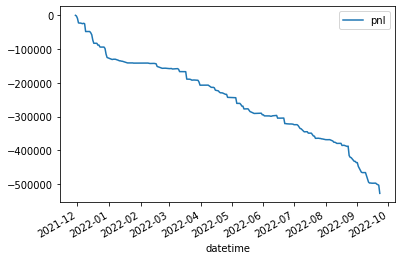

In [228]:
df.set_index('datetime').cumsum().plot()#[datetime(2022,1,1):].cumsum()#.plot()# [datetime(2022,1,1):]